### 介绍 \ Introduction

这一节介绍的是如何用FLGo实现在用户采样阶段做出修改的算法。这里使用的例子是PowerOfChoice，该算法由Cho等人于2020年提出（[论文链接](https://arxiv.org/abs/2010.01243)）。该方法相较于传统的无偏采样策略，使用了一种有偏但能够更快收敛的采样方式，即优先采样那些本地数据集损失较大的用户。为了达到这个目的，它的采样步骤概括如下：

1. 服务器从所有$K$个用户中按数据集大小比例不放回采样$d$个候选用户 ($m<=d<=K$，$m$为服务器本轮实际采样用户数目)；
2. 服务器广播当前全局模型$\theta^t$给$d$个候选用户，评估它们的本地数据集损失，这些用户发回损失值$F_k(\theta^t)$；
3. 服务器根据$d$个候选用户发回的损失值进行排序，优先选取前$m$个损失最大的用户参与本轮训练

下面讲解如何用FLGo实现该采样策略。

## 使用FLGo实现Power Of Choice 

In [ ]:
import numpy as np
import flgo.algorithm.fedavg as fedavg
from flgo.algorithm.fedbase import BasicServer
import flgo.system_simulator.base as ss
import os
import flgo

class Server(BasicServer):
    def initialize(self, *args, **kwargs):
        self.init_algo_para({'d': self.num_clients})

    @ss.with_availability
    def sample(self):
        # create candidate set A
        num_candidate = min(self.d, len(self.available_clients))
        p_candidate = np.array([len(self.clients[cid].train_data) for cid in self.available_clients])
        candidate_set = np.random.choice(self.available_clients, num_candidate, p=p_candidate / p_candidate.sum(), replace=False)
        candidate_set = sorted(candidate_set)
        # communicate with the candidates for their local loss
        losses = []
        for cid in candidate_set:
            losses.append(self.clients[cid].test(self.model, dataflag='train')['loss'])
        # sort candidate set according to their local loss value, and choose the top-M highest ones
        sort_id = np.array(losses).argsort().tolist()
        sort_id.reverse()
        num_selected = min(self.clients_per_round, len(self.available_clients))
        selected_clients = np.array(self.available_clients)[sort_id][:num_selected]
        return selected_clients.tolist()

class powerofchoice:
    Server=Server
    Client=fedavg.Client

首先，算法有个超参数d，用来控制候选者的数目，因此在初始化方法initialize中实现该超参数，并设置默认值为全体用户数目；

接着，确定候选者数目为当前活跃用户和d的较小值，根据其数据集大小比例采样得到候选者集合candidate_set；

然后这里为了方便起见，不重写通信相关的内容，直接调用候选者们的测试函数，来获得他们的本地数据集损失（两者效果等价，重写通信相关的代码则更加麻烦）。然后根据损失对候选者集合进行排序。

最后选取前self.clients_per_round个损失最大的用户，并返回他们的id。

注：sample方法的装饰器ss.with_availability是为了即时刷新用户的可用性，该功能是为了实现系统异构型，在后续的章节将会进行讲解

## 测试Power Of Choice

这里尝试在Synthetic(1,1)-30 client数据集上测试所实现的power of choice。除了学习率衰减变为每轮衰减0.998，其余保持跟原文实验中一致（Figure3 第三幅图，每轮采$m =30*proportion=3$个人，$d=30$）。

In [2]:
task = './synthetic1-1'
config = {'benchmark':{'name':'flgo.benchmark.synthetic_regression', 'para':{'alpha':1, 'beta':1, 'num_clients':30}}}
if not os.path.exists(task): flgo.gen_task(config, task_path = task)
option = {'num_rounds':750, 'num_steps':30, 'batch_size':50, 'learning_rate':0.05, 'gpu':0, 'proportion':0.1,'lr_scheduler':0}
poc_runner = flgo.init(task, powerofchoice, option=option)
fedavg_runner = flgo.init(task, fedavg, option=option)
poc_runner.run()
fedavg_runner.run()

2023-03-14 15:19:36,441 fedbase.py run [line:121] INFO Eval Time Cost:               0.0595s
2023-03-14 15:19:36,680 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2391s
2023-03-14 15:19:36,681 fedbase.py run [line:116] INFO --------------Round 31--------------
2023-03-14 15:19:36,681 simple_logger.py log_once [line:13] INFO Current_time:31
2023-03-14 15:19:36,734 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7772
2023-03-14 15:19:36,734 simple_logger.py log_once [line:27] INFO test_loss                     0.8773
2023-03-14 15:19:36,735 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7902
2023-03-14 15:19:36,735 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7902
2023-03-14 15:19:36,735 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2053
2023-03-14 15:19:36,736 simple_logger.py log_once [line:27] INFO valid_loss                    0.8485
2023-03-14 15:19:36,736 simpl

2023-03-14 15:19:39,273 fedbase.py run [line:121] INFO Eval Time Cost:               0.0723s
2023-03-14 15:19:39,504 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2308s
2023-03-14 15:19:39,505 fedbase.py run [line:116] INFO --------------Round 38--------------
2023-03-14 15:19:39,505 simple_logger.py log_once [line:13] INFO Current_time:38
2023-03-14 15:19:39,579 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8017
2023-03-14 15:19:39,579 simple_logger.py log_once [line:27] INFO test_loss                     0.8126
2023-03-14 15:19:39,579 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8039
2023-03-14 15:19:39,580 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8039
2023-03-14 15:19:39,580 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1736
2023-03-14 15:19:39,580 simple_logger.py log_once [line:27] INFO valid_loss                    0.7863
2023-03-14 15:19:39,580 simpl

2023-03-14 15:19:41,351 fedbase.py run [line:121] INFO Eval Time Cost:               0.0598s
2023-03-14 15:19:41,794 fedbase.py run [line:113] INFO Iterate Time Cost:            0.4430s
2023-03-14 15:19:41,795 fedbase.py run [line:116] INFO --------------Round 45--------------
2023-03-14 15:19:41,796 simple_logger.py log_once [line:13] INFO Current_time:45
2023-03-14 15:19:41,951 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8028
2023-03-14 15:19:41,951 simple_logger.py log_once [line:27] INFO test_loss                     0.7482
2023-03-14 15:19:41,951 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8186
2023-03-14 15:19:41,952 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8186
2023-03-14 15:19:41,952 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1791
2023-03-14 15:19:41,952 simple_logger.py log_once [line:27] INFO valid_loss                    0.7238
2023-03-14 15:19:41,953 simpl

2023-03-14 15:19:44,047 fedbase.py run [line:121] INFO Eval Time Cost:               0.0754s
2023-03-14 15:19:44,263 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2153s
2023-03-14 15:19:44,263 fedbase.py run [line:116] INFO --------------Round 52--------------
2023-03-14 15:19:44,263 simple_logger.py log_once [line:13] INFO Current_time:52
2023-03-14 15:19:44,332 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7878
2023-03-14 15:19:44,332 simple_logger.py log_once [line:27] INFO test_loss                     0.7535
2023-03-14 15:19:44,333 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7922
2023-03-14 15:19:44,333 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7922
2023-03-14 15:19:44,333 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1751
2023-03-14 15:19:44,333 simple_logger.py log_once [line:27] INFO valid_loss                    0.7224
2023-03-14 15:19:44,334 simpl

2023-03-14 15:19:46,262 fedbase.py run [line:121] INFO Eval Time Cost:               0.2107s
2023-03-14 15:19:46,768 fedbase.py run [line:113] INFO Iterate Time Cost:            0.5060s
2023-03-14 15:19:46,769 fedbase.py run [line:116] INFO --------------Round 59--------------
2023-03-14 15:19:46,769 simple_logger.py log_once [line:13] INFO Current_time:59
2023-03-14 15:19:46,909 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8311
2023-03-14 15:19:46,909 simple_logger.py log_once [line:27] INFO test_loss                     0.6391
2023-03-14 15:19:46,910 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8422
2023-03-14 15:19:46,910 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8422
2023-03-14 15:19:46,910 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1654
2023-03-14 15:19:46,910 simple_logger.py log_once [line:27] INFO valid_loss                    0.6178
2023-03-14 15:19:46,911 simpl

2023-03-14 15:19:48,747 fedbase.py run [line:121] INFO Eval Time Cost:               0.0733s
2023-03-14 15:19:48,962 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2153s
2023-03-14 15:19:48,963 fedbase.py run [line:116] INFO --------------Round 66--------------
2023-03-14 15:19:48,963 simple_logger.py log_once [line:13] INFO Current_time:66
2023-03-14 15:19:48,999 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8339
2023-03-14 15:19:48,999 simple_logger.py log_once [line:27] INFO test_loss                     0.6445
2023-03-14 15:19:49,000 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8461
2023-03-14 15:19:49,000 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8461
2023-03-14 15:19:49,000 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1520
2023-03-14 15:19:49,001 simple_logger.py log_once [line:27] INFO valid_loss                    0.6233
2023-03-14 15:19:49,001 simpl

2023-03-14 15:19:50,684 fedbase.py run [line:121] INFO Eval Time Cost:               0.0585s
2023-03-14 15:19:50,911 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2261s
2023-03-14 15:19:50,911 fedbase.py run [line:116] INFO --------------Round 73--------------
2023-03-14 15:19:50,912 simple_logger.py log_once [line:13] INFO Current_time:73
2023-03-14 15:19:50,967 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7717
2023-03-14 15:19:50,968 simple_logger.py log_once [line:27] INFO test_loss                     0.7568
2023-03-14 15:19:50,968 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7716
2023-03-14 15:19:50,968 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7716
2023-03-14 15:19:50,969 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2088
2023-03-14 15:19:50,969 simple_logger.py log_once [line:27] INFO valid_loss                    0.7193
2023-03-14 15:19:50,969 simpl

2023-03-14 15:19:53,500 fedbase.py run [line:121] INFO Eval Time Cost:               0.0699s
2023-03-14 15:19:53,722 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2222s
2023-03-14 15:19:53,723 fedbase.py run [line:116] INFO --------------Round 80--------------
2023-03-14 15:19:53,723 simple_logger.py log_once [line:13] INFO Current_time:80
2023-03-14 15:19:53,765 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8139
2023-03-14 15:19:53,765 simple_logger.py log_once [line:27] INFO test_loss                     0.6413
2023-03-14 15:19:53,765 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8225
2023-03-14 15:19:53,766 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8225
2023-03-14 15:19:53,766 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1668
2023-03-14 15:19:53,767 simple_logger.py log_once [line:27] INFO valid_loss                    0.6199
2023-03-14 15:19:53,767 simpl

2023-03-14 15:19:55,243 fedbase.py run [line:121] INFO Eval Time Cost:               0.0283s
2023-03-14 15:19:55,396 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1524s
2023-03-14 15:19:55,396 fedbase.py run [line:116] INFO --------------Round 87--------------
2023-03-14 15:19:55,396 simple_logger.py log_once [line:13] INFO Current_time:87
2023-03-14 15:19:55,425 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8150
2023-03-14 15:19:55,425 simple_logger.py log_once [line:27] INFO test_loss                     0.6923
2023-03-14 15:19:55,425 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8245
2023-03-14 15:19:55,426 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8245
2023-03-14 15:19:55,426 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1576
2023-03-14 15:19:55,426 simple_logger.py log_once [line:27] INFO valid_loss                    0.6552
2023-03-14 15:19:55,426 simpl

2023-03-14 15:19:57,045 fedbase.py run [line:121] INFO Eval Time Cost:               0.0590s
2023-03-14 15:19:57,173 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1279s
2023-03-14 15:19:57,173 fedbase.py run [line:116] INFO --------------Round 94--------------
2023-03-14 15:19:57,174 simple_logger.py log_once [line:13] INFO Current_time:94
2023-03-14 15:19:57,195 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8078
2023-03-14 15:19:57,195 simple_logger.py log_once [line:27] INFO test_loss                     0.6865
2023-03-14 15:19:57,196 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8167
2023-03-14 15:19:57,196 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8167
2023-03-14 15:19:57,196 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1583
2023-03-14 15:19:57,196 simple_logger.py log_once [line:27] INFO valid_loss                    0.6570
2023-03-14 15:19:57,197 simpl

2023-03-14 15:19:58,534 fedbase.py run [line:121] INFO Eval Time Cost:               0.0437s
2023-03-14 15:19:58,784 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2497s
2023-03-14 15:19:58,785 fedbase.py run [line:116] INFO --------------Round 101--------------
2023-03-14 15:19:58,785 simple_logger.py log_once [line:13] INFO Current_time:101
2023-03-14 15:19:58,844 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8056
2023-03-14 15:19:58,844 simple_logger.py log_once [line:27] INFO test_loss                     0.6748
2023-03-14 15:19:58,845 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8137
2023-03-14 15:19:58,845 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8137
2023-03-14 15:19:58,845 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1516
2023-03-14 15:19:58,845 simple_logger.py log_once [line:27] INFO valid_loss                    0.6535
2023-03-14 15:19:58,846 sim

2023-03-14 15:20:01,319 fedbase.py run [line:121] INFO Eval Time Cost:               0.2430s
2023-03-14 15:20:01,639 fedbase.py run [line:113] INFO Iterate Time Cost:            0.3199s
2023-03-14 15:20:01,640 fedbase.py run [line:116] INFO --------------Round 108--------------
2023-03-14 15:20:01,640 simple_logger.py log_once [line:13] INFO Current_time:108
2023-03-14 15:20:01,701 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7844
2023-03-14 15:20:01,702 simple_logger.py log_once [line:27] INFO test_loss                     0.6701
2023-03-14 15:20:01,702 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7745
2023-03-14 15:20:01,702 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7745
2023-03-14 15:20:01,703 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2079
2023-03-14 15:20:01,703 simple_logger.py log_once [line:27] INFO valid_loss                    0.6630
2023-03-14 15:20:01,703 sim

2023-03-14 15:20:03,517 fedbase.py run [line:121] INFO Eval Time Cost:               0.0630s
2023-03-14 15:20:03,757 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2392s
2023-03-14 15:20:03,757 fedbase.py run [line:116] INFO --------------Round 115--------------
2023-03-14 15:20:03,757 simple_logger.py log_once [line:13] INFO Current_time:115
2023-03-14 15:20:03,814 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8233
2023-03-14 15:20:03,815 simple_logger.py log_once [line:27] INFO test_loss                     0.6057
2023-03-14 15:20:03,815 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8412
2023-03-14 15:20:03,815 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8412
2023-03-14 15:20:03,815 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1528
2023-03-14 15:20:03,816 simple_logger.py log_once [line:27] INFO valid_loss                    0.5887
2023-03-14 15:20:03,816 sim

2023-03-14 15:20:06,447 fedbase.py run [line:121] INFO Eval Time Cost:               0.0726s
2023-03-14 15:20:06,672 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2245s
2023-03-14 15:20:06,672 fedbase.py run [line:116] INFO --------------Round 122--------------
2023-03-14 15:20:06,672 simple_logger.py log_once [line:13] INFO Current_time:122
2023-03-14 15:20:06,738 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8194
2023-03-14 15:20:06,739 simple_logger.py log_once [line:27] INFO test_loss                     0.6544
2023-03-14 15:20:06,739 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8059
2023-03-14 15:20:06,739 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8059
2023-03-14 15:20:06,740 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1743
2023-03-14 15:20:06,740 simple_logger.py log_once [line:27] INFO valid_loss                    0.6275
2023-03-14 15:20:06,740 sim

2023-03-14 15:20:08,550 fedbase.py run [line:121] INFO Eval Time Cost:               0.0613s
2023-03-14 15:20:08,783 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2329s
2023-03-14 15:20:08,784 fedbase.py run [line:116] INFO --------------Round 129--------------
2023-03-14 15:20:08,784 simple_logger.py log_once [line:13] INFO Current_time:129
2023-03-14 15:20:08,848 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8083
2023-03-14 15:20:08,848 simple_logger.py log_once [line:27] INFO test_loss                     0.6266
2023-03-14 15:20:08,848 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8167
2023-03-14 15:20:08,849 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8167
2023-03-14 15:20:08,849 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1533
2023-03-14 15:20:08,849 simple_logger.py log_once [line:27] INFO valid_loss                    0.6075
2023-03-14 15:20:08,850 sim

2023-03-14 15:20:11,474 fedbase.py run [line:121] INFO Eval Time Cost:               0.0415s
2023-03-14 15:20:11,699 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2247s
2023-03-14 15:20:11,699 fedbase.py run [line:116] INFO --------------Round 136--------------
2023-03-14 15:20:11,700 simple_logger.py log_once [line:13] INFO Current_time:136
2023-03-14 15:20:11,752 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7794
2023-03-14 15:20:11,752 simple_logger.py log_once [line:27] INFO test_loss                     0.6808
2023-03-14 15:20:11,752 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7735
2023-03-14 15:20:11,753 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7735
2023-03-14 15:20:11,753 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1912
2023-03-14 15:20:11,753 simple_logger.py log_once [line:27] INFO valid_loss                    0.6637
2023-03-14 15:20:11,753 sim

2023-03-14 15:20:13,508 fedbase.py run [line:121] INFO Eval Time Cost:               0.0561s
2023-03-14 15:20:13,735 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2270s
2023-03-14 15:20:13,735 fedbase.py run [line:116] INFO --------------Round 143--------------
2023-03-14 15:20:13,735 simple_logger.py log_once [line:13] INFO Current_time:143
2023-03-14 15:20:13,789 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8161
2023-03-14 15:20:13,790 simple_logger.py log_once [line:27] INFO test_loss                     0.6132
2023-03-14 15:20:13,790 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8206
2023-03-14 15:20:13,790 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8206
2023-03-14 15:20:13,791 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1656
2023-03-14 15:20:13,791 simple_logger.py log_once [line:27] INFO valid_loss                    0.5848
2023-03-14 15:20:13,791 sim

2023-03-14 15:20:16,333 fedbase.py run [line:121] INFO Eval Time Cost:               0.0714s
2023-03-14 15:20:16,549 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2154s
2023-03-14 15:20:16,549 fedbase.py run [line:116] INFO --------------Round 150--------------
2023-03-14 15:20:16,550 simple_logger.py log_once [line:13] INFO Current_time:150
2023-03-14 15:20:16,619 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7744
2023-03-14 15:20:16,620 simple_logger.py log_once [line:27] INFO test_loss                     0.6798
2023-03-14 15:20:16,620 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7755
2023-03-14 15:20:16,620 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7755
2023-03-14 15:20:16,621 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1855
2023-03-14 15:20:16,621 simple_logger.py log_once [line:27] INFO valid_loss                    0.6553
2023-03-14 15:20:16,621 sim

2023-03-14 15:20:18,346 fedbase.py run [line:121] INFO Eval Time Cost:               0.0555s
2023-03-14 15:20:18,570 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2244s
2023-03-14 15:20:18,571 fedbase.py run [line:116] INFO --------------Round 157--------------
2023-03-14 15:20:18,571 simple_logger.py log_once [line:13] INFO Current_time:157
2023-03-14 15:20:18,617 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7967
2023-03-14 15:20:18,618 simple_logger.py log_once [line:27] INFO test_loss                     0.6359
2023-03-14 15:20:18,618 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8098
2023-03-14 15:20:18,618 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8098
2023-03-14 15:20:18,619 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1548
2023-03-14 15:20:18,619 simple_logger.py log_once [line:27] INFO valid_loss                    0.6099
2023-03-14 15:20:18,619 sim

2023-03-14 15:20:21,180 fedbase.py run [line:121] INFO Eval Time Cost:               0.0430s
2023-03-14 15:20:21,403 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2232s
2023-03-14 15:20:21,404 fedbase.py run [line:116] INFO --------------Round 164--------------
2023-03-14 15:20:21,404 simple_logger.py log_once [line:13] INFO Current_time:164
2023-03-14 15:20:21,460 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7978
2023-03-14 15:20:21,460 simple_logger.py log_once [line:27] INFO test_loss                     0.6362
2023-03-14 15:20:21,461 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8147
2023-03-14 15:20:21,461 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8147
2023-03-14 15:20:21,461 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1365
2023-03-14 15:20:21,461 simple_logger.py log_once [line:27] INFO valid_loss                    0.6179
2023-03-14 15:20:21,462 sim

2023-03-14 15:20:23,183 fedbase.py run [line:121] INFO Eval Time Cost:               0.0552s
2023-03-14 15:20:23,414 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2303s
2023-03-14 15:20:23,414 fedbase.py run [line:116] INFO --------------Round 171--------------
2023-03-14 15:20:23,414 simple_logger.py log_once [line:13] INFO Current_time:171
2023-03-14 15:20:23,462 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8261
2023-03-14 15:20:23,463 simple_logger.py log_once [line:27] INFO test_loss                     0.5894
2023-03-14 15:20:23,463 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8235
2023-03-14 15:20:23,463 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8235
2023-03-14 15:20:23,463 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1459
2023-03-14 15:20:23,464 simple_logger.py log_once [line:27] INFO valid_loss                    0.5804
2023-03-14 15:20:23,464 sim

2023-03-14 15:20:25,962 fedbase.py run [line:121] INFO Eval Time Cost:               0.0420s
2023-03-14 15:20:26,204 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2415s
2023-03-14 15:20:26,205 fedbase.py run [line:116] INFO --------------Round 178--------------
2023-03-14 15:20:26,205 simple_logger.py log_once [line:13] INFO Current_time:178
2023-03-14 15:20:26,245 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8222
2023-03-14 15:20:26,245 simple_logger.py log_once [line:27] INFO test_loss                     0.6045
2023-03-14 15:20:26,246 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8235
2023-03-14 15:20:26,246 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8235
2023-03-14 15:20:26,246 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1400
2023-03-14 15:20:26,246 simple_logger.py log_once [line:27] INFO valid_loss                    0.5988
2023-03-14 15:20:26,247 sim

2023-03-14 15:20:27,986 fedbase.py run [line:121] INFO Eval Time Cost:               0.0565s
2023-03-14 15:20:28,213 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2266s
2023-03-14 15:20:28,213 fedbase.py run [line:116] INFO --------------Round 185--------------
2023-03-14 15:20:28,213 simple_logger.py log_once [line:13] INFO Current_time:185
2023-03-14 15:20:28,268 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8017
2023-03-14 15:20:28,268 simple_logger.py log_once [line:27] INFO test_loss                     0.6108
2023-03-14 15:20:28,268 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8010
2023-03-14 15:20:28,269 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8010
2023-03-14 15:20:28,269 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1684
2023-03-14 15:20:28,269 simple_logger.py log_once [line:27] INFO valid_loss                    0.6050
2023-03-14 15:20:28,270 sim

2023-03-14 15:20:30,747 fedbase.py run [line:121] INFO Eval Time Cost:               0.0448s
2023-03-14 15:20:31,000 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2532s
2023-03-14 15:20:31,001 fedbase.py run [line:116] INFO --------------Round 192--------------
2023-03-14 15:20:31,001 simple_logger.py log_once [line:13] INFO Current_time:192
2023-03-14 15:20:31,042 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8383
2023-03-14 15:20:31,043 simple_logger.py log_once [line:27] INFO test_loss                     0.5363
2023-03-14 15:20:31,043 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8569
2023-03-14 15:20:31,043 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8569
2023-03-14 15:20:31,044 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1426
2023-03-14 15:20:31,044 simple_logger.py log_once [line:27] INFO valid_loss                    0.5245
2023-03-14 15:20:31,044 sim

2023-03-14 15:20:32,830 fedbase.py run [line:121] INFO Eval Time Cost:               0.0547s
2023-03-14 15:20:33,062 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2313s
2023-03-14 15:20:33,063 fedbase.py run [line:116] INFO --------------Round 199--------------
2023-03-14 15:20:33,063 simple_logger.py log_once [line:13] INFO Current_time:199
2023-03-14 15:20:33,123 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8333
2023-03-14 15:20:33,123 simple_logger.py log_once [line:27] INFO test_loss                     0.5444
2023-03-14 15:20:33,124 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8569
2023-03-14 15:20:33,124 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8569
2023-03-14 15:20:33,124 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1377
2023-03-14 15:20:33,124 simple_logger.py log_once [line:27] INFO valid_loss                    0.5282
2023-03-14 15:20:33,125 sim

2023-03-14 15:20:35,749 fedbase.py run [line:121] INFO Eval Time Cost:               0.0746s
2023-03-14 15:20:35,959 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2099s
2023-03-14 15:20:35,960 fedbase.py run [line:116] INFO --------------Round 206--------------
2023-03-14 15:20:35,960 simple_logger.py log_once [line:13] INFO Current_time:206
2023-03-14 15:20:36,002 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8306
2023-03-14 15:20:36,002 simple_logger.py log_once [line:27] INFO test_loss                     0.5598
2023-03-14 15:20:36,002 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8471
2023-03-14 15:20:36,003 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8471
2023-03-14 15:20:36,003 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1397
2023-03-14 15:20:36,003 simple_logger.py log_once [line:27] INFO valid_loss                    0.5457
2023-03-14 15:20:36,003 sim

2023-03-14 15:20:37,804 fedbase.py run [line:121] INFO Eval Time Cost:               0.0581s
2023-03-14 15:20:38,286 fedbase.py run [line:113] INFO Iterate Time Cost:            0.4811s
2023-03-14 15:20:38,286 fedbase.py run [line:116] INFO --------------Round 213--------------
2023-03-14 15:20:38,287 simple_logger.py log_once [line:13] INFO Current_time:213
2023-03-14 15:20:38,529 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8250
2023-03-14 15:20:38,530 simple_logger.py log_once [line:27] INFO test_loss                     0.5777
2023-03-14 15:20:38,530 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8275
2023-03-14 15:20:38,530 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8275
2023-03-14 15:20:38,531 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1460
2023-03-14 15:20:38,531 simple_logger.py log_once [line:27] INFO valid_loss                    0.5734
2023-03-14 15:20:38,531 sim

2023-03-14 15:20:40,610 fedbase.py run [line:121] INFO Eval Time Cost:               0.0444s
2023-03-14 15:20:40,832 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2224s
2023-03-14 15:20:40,833 fedbase.py run [line:116] INFO --------------Round 220--------------
2023-03-14 15:20:40,833 simple_logger.py log_once [line:13] INFO Current_time:220
2023-03-14 15:20:40,903 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7839
2023-03-14 15:20:40,903 simple_logger.py log_once [line:27] INFO test_loss                     0.6358
2023-03-14 15:20:40,903 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7912
2023-03-14 15:20:40,904 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7912
2023-03-14 15:20:40,904 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1430
2023-03-14 15:20:40,904 simple_logger.py log_once [line:27] INFO valid_loss                    0.6238
2023-03-14 15:20:40,904 sim

2023-03-14 15:20:42,787 fedbase.py run [line:121] INFO Eval Time Cost:               0.2224s
2023-03-14 15:20:43,286 fedbase.py run [line:113] INFO Iterate Time Cost:            0.4986s
2023-03-14 15:20:43,286 fedbase.py run [line:116] INFO --------------Round 227--------------
2023-03-14 15:20:43,287 simple_logger.py log_once [line:13] INFO Current_time:227
2023-03-14 15:20:43,503 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8194
2023-03-14 15:20:43,504 simple_logger.py log_once [line:27] INFO test_loss                     0.5828
2023-03-14 15:20:43,504 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8216
2023-03-14 15:20:43,504 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8216
2023-03-14 15:20:43,505 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1478
2023-03-14 15:20:43,505 simple_logger.py log_once [line:27] INFO valid_loss                    0.5793
2023-03-14 15:20:43,505 sim

2023-03-14 15:20:45,439 fedbase.py run [line:121] INFO Eval Time Cost:               0.0426s
2023-03-14 15:20:45,672 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2321s
2023-03-14 15:20:45,672 fedbase.py run [line:116] INFO --------------Round 234--------------
2023-03-14 15:20:45,673 simple_logger.py log_once [line:13] INFO Current_time:234
2023-03-14 15:20:45,726 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8189
2023-03-14 15:20:45,726 simple_logger.py log_once [line:27] INFO test_loss                     0.5785
2023-03-14 15:20:45,726 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8137
2023-03-14 15:20:45,727 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8137
2023-03-14 15:20:45,727 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1564
2023-03-14 15:20:45,727 simple_logger.py log_once [line:27] INFO valid_loss                    0.5702
2023-03-14 15:20:45,728 sim

2023-03-14 15:20:48,082 fedbase.py run [line:121] INFO Eval Time Cost:               0.1887s
2023-03-14 15:20:48,607 fedbase.py run [line:113] INFO Iterate Time Cost:            0.5251s
2023-03-14 15:20:48,607 fedbase.py run [line:116] INFO --------------Round 241--------------
2023-03-14 15:20:48,608 simple_logger.py log_once [line:13] INFO Current_time:241
2023-03-14 15:20:48,650 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8200
2023-03-14 15:20:48,651 simple_logger.py log_once [line:27] INFO test_loss                     0.5632
2023-03-14 15:20:48,651 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8343
2023-03-14 15:20:48,651 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8343
2023-03-14 15:20:48,652 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1391
2023-03-14 15:20:48,652 simple_logger.py log_once [line:27] INFO valid_loss                    0.5465
2023-03-14 15:20:48,652 sim

2023-03-14 15:20:50,435 fedbase.py run [line:121] INFO Eval Time Cost:               0.0748s
2023-03-14 15:20:50,683 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2484s
2023-03-14 15:20:50,684 fedbase.py run [line:116] INFO --------------Round 248--------------
2023-03-14 15:20:50,684 simple_logger.py log_once [line:13] INFO Current_time:248
2023-03-14 15:20:50,741 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8072
2023-03-14 15:20:50,741 simple_logger.py log_once [line:27] INFO test_loss                     0.5899
2023-03-14 15:20:50,742 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8225
2023-03-14 15:20:50,742 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8225
2023-03-14 15:20:50,742 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1403
2023-03-14 15:20:50,743 simple_logger.py log_once [line:27] INFO valid_loss                    0.5738
2023-03-14 15:20:50,743 sim

2023-03-14 15:20:53,440 fedbase.py run [line:121] INFO Eval Time Cost:               0.0426s
2023-03-14 15:20:53,663 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2216s
2023-03-14 15:20:53,663 fedbase.py run [line:116] INFO --------------Round 255--------------
2023-03-14 15:20:53,663 simple_logger.py log_once [line:13] INFO Current_time:255
2023-03-14 15:20:53,734 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8167
2023-03-14 15:20:53,735 simple_logger.py log_once [line:27] INFO test_loss                     0.5895
2023-03-14 15:20:53,735 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8255
2023-03-14 15:20:53,735 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8255
2023-03-14 15:20:53,736 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1455
2023-03-14 15:20:53,736 simple_logger.py log_once [line:27] INFO valid_loss                    0.5698
2023-03-14 15:20:53,737 sim

2023-03-14 15:20:55,552 fedbase.py run [line:121] INFO Eval Time Cost:               0.0671s
2023-03-14 15:20:55,793 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2398s
2023-03-14 15:20:55,793 fedbase.py run [line:116] INFO --------------Round 262--------------
2023-03-14 15:20:55,793 simple_logger.py log_once [line:13] INFO Current_time:262
2023-03-14 15:20:55,858 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8094
2023-03-14 15:20:55,859 simple_logger.py log_once [line:27] INFO test_loss                     0.5807
2023-03-14 15:20:55,859 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8294
2023-03-14 15:20:55,859 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8294
2023-03-14 15:20:55,860 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1389
2023-03-14 15:20:55,860 simple_logger.py log_once [line:27] INFO valid_loss                    0.5642
2023-03-14 15:20:55,860 sim

2023-03-14 15:20:58,598 fedbase.py run [line:121] INFO Eval Time Cost:               0.0749s
2023-03-14 15:20:58,823 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2246s
2023-03-14 15:20:58,823 fedbase.py run [line:116] INFO --------------Round 269--------------
2023-03-14 15:20:58,823 simple_logger.py log_once [line:13] INFO Current_time:269
2023-03-14 15:20:58,894 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8128
2023-03-14 15:20:58,894 simple_logger.py log_once [line:27] INFO test_loss                     0.5778
2023-03-14 15:20:58,894 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8275
2023-03-14 15:20:58,895 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8275
2023-03-14 15:20:58,895 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1366
2023-03-14 15:20:58,895 simple_logger.py log_once [line:27] INFO valid_loss                    0.5678
2023-03-14 15:20:58,896 sim

2023-03-14 15:21:00,712 fedbase.py run [line:121] INFO Eval Time Cost:               0.0597s
2023-03-14 15:21:00,950 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2374s
2023-03-14 15:21:00,950 fedbase.py run [line:116] INFO --------------Round 276--------------
2023-03-14 15:21:00,950 simple_logger.py log_once [line:13] INFO Current_time:276
2023-03-14 15:21:01,007 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8089
2023-03-14 15:21:01,008 simple_logger.py log_once [line:27] INFO test_loss                     0.5877
2023-03-14 15:21:01,008 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8196
2023-03-14 15:21:01,008 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8196
2023-03-14 15:21:01,009 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1398
2023-03-14 15:21:01,009 simple_logger.py log_once [line:27] INFO valid_loss                    0.5781
2023-03-14 15:21:01,009 sim

2023-03-14 15:21:03,558 fedbase.py run [line:121] INFO Eval Time Cost:               0.0433s
2023-03-14 15:21:03,772 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2138s
2023-03-14 15:21:03,772 fedbase.py run [line:116] INFO --------------Round 283--------------
2023-03-14 15:21:03,772 simple_logger.py log_once [line:13] INFO Current_time:283
2023-03-14 15:21:03,834 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8139
2023-03-14 15:21:03,835 simple_logger.py log_once [line:27] INFO test_loss                     0.5795
2023-03-14 15:21:03,835 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8118
2023-03-14 15:21:03,835 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8118
2023-03-14 15:21:03,836 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1364
2023-03-14 15:21:03,836 simple_logger.py log_once [line:27] INFO valid_loss                    0.5736
2023-03-14 15:21:03,836 sim

2023-03-14 15:21:05,480 fedbase.py run [line:121] INFO Eval Time Cost:               0.0539s
2023-03-14 15:21:05,705 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2246s
2023-03-14 15:21:05,705 fedbase.py run [line:116] INFO --------------Round 290--------------
2023-03-14 15:21:05,705 simple_logger.py log_once [line:13] INFO Current_time:290
2023-03-14 15:21:05,760 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8050
2023-03-14 15:21:05,760 simple_logger.py log_once [line:27] INFO test_loss                     0.5896
2023-03-14 15:21:05,760 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8078
2023-03-14 15:21:05,760 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8078
2023-03-14 15:21:05,761 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1358
2023-03-14 15:21:05,761 simple_logger.py log_once [line:27] INFO valid_loss                    0.5821
2023-03-14 15:21:05,761 sim

2023-03-14 15:21:08,086 fedbase.py run [line:121] INFO Eval Time Cost:               0.0662s
2023-03-14 15:21:08,294 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2070s
2023-03-14 15:21:08,294 fedbase.py run [line:116] INFO --------------Round 297--------------
2023-03-14 15:21:08,294 simple_logger.py log_once [line:13] INFO Current_time:297
2023-03-14 15:21:08,334 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8178
2023-03-14 15:21:08,335 simple_logger.py log_once [line:27] INFO test_loss                     0.5843
2023-03-14 15:21:08,335 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8167
2023-03-14 15:21:08,335 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8167
2023-03-14 15:21:08,335 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1398
2023-03-14 15:21:08,336 simple_logger.py log_once [line:27] INFO valid_loss                    0.5731
2023-03-14 15:21:08,336 sim

2023-03-14 15:21:10,018 fedbase.py run [line:121] INFO Eval Time Cost:               0.0564s
2023-03-14 15:21:10,235 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2168s
2023-03-14 15:21:10,235 fedbase.py run [line:116] INFO --------------Round 304--------------
2023-03-14 15:21:10,235 simple_logger.py log_once [line:13] INFO Current_time:304
2023-03-14 15:21:10,288 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8028
2023-03-14 15:21:10,288 simple_logger.py log_once [line:27] INFO test_loss                     0.5942
2023-03-14 15:21:10,288 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8137
2023-03-14 15:21:10,289 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8137
2023-03-14 15:21:10,289 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1314
2023-03-14 15:21:10,289 simple_logger.py log_once [line:27] INFO valid_loss                    0.5854
2023-03-14 15:21:10,289 sim

2023-03-14 15:21:12,829 fedbase.py run [line:121] INFO Eval Time Cost:               0.0707s
2023-03-14 15:21:13,044 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2151s
2023-03-14 15:21:13,045 fedbase.py run [line:116] INFO --------------Round 311--------------
2023-03-14 15:21:13,045 simple_logger.py log_once [line:13] INFO Current_time:311
2023-03-14 15:21:13,084 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8011
2023-03-14 15:21:13,085 simple_logger.py log_once [line:27] INFO test_loss                     0.5981
2023-03-14 15:21:13,085 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8137
2023-03-14 15:21:13,085 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8137
2023-03-14 15:21:13,086 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1292
2023-03-14 15:21:13,086 simple_logger.py log_once [line:27] INFO valid_loss                    0.5842
2023-03-14 15:21:13,086 sim

2023-03-14 15:21:14,722 fedbase.py run [line:121] INFO Eval Time Cost:               0.0568s
2023-03-14 15:21:14,975 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2523s
2023-03-14 15:21:14,975 fedbase.py run [line:116] INFO --------------Round 318--------------
2023-03-14 15:21:14,975 simple_logger.py log_once [line:13] INFO Current_time:318
2023-03-14 15:21:15,030 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8094
2023-03-14 15:21:15,031 simple_logger.py log_once [line:27] INFO test_loss                     0.5720
2023-03-14 15:21:15,031 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8275
2023-03-14 15:21:15,031 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8275
2023-03-14 15:21:15,032 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1354
2023-03-14 15:21:15,032 simple_logger.py log_once [line:27] INFO valid_loss                    0.5613
2023-03-14 15:21:15,032 sim

2023-03-14 15:21:17,437 fedbase.py run [line:121] INFO Eval Time Cost:               0.0365s
2023-03-14 15:21:17,677 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2402s
2023-03-14 15:21:17,678 fedbase.py run [line:116] INFO --------------Round 325--------------
2023-03-14 15:21:17,678 simple_logger.py log_once [line:13] INFO Current_time:325
2023-03-14 15:21:17,717 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8089
2023-03-14 15:21:17,718 simple_logger.py log_once [line:27] INFO test_loss                     0.5884
2023-03-14 15:21:17,718 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8147
2023-03-14 15:21:17,718 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8147
2023-03-14 15:21:17,718 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1382
2023-03-14 15:21:17,719 simple_logger.py log_once [line:27] INFO valid_loss                    0.5717
2023-03-14 15:21:17,719 sim

2023-03-14 15:21:19,415 fedbase.py run [line:121] INFO Eval Time Cost:               0.0583s
2023-03-14 15:21:19,637 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2213s
2023-03-14 15:21:19,637 fedbase.py run [line:116] INFO --------------Round 332--------------
2023-03-14 15:21:19,638 simple_logger.py log_once [line:13] INFO Current_time:332
2023-03-14 15:21:19,695 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8050
2023-03-14 15:21:19,696 simple_logger.py log_once [line:27] INFO test_loss                     0.5689
2023-03-14 15:21:19,696 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8225
2023-03-14 15:21:19,696 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8225
2023-03-14 15:21:19,696 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1436
2023-03-14 15:21:19,697 simple_logger.py log_once [line:27] INFO valid_loss                    0.5540
2023-03-14 15:21:19,697 sim

2023-03-14 15:21:22,302 fedbase.py run [line:121] INFO Eval Time Cost:               0.0749s
2023-03-14 15:21:22,528 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2242s
2023-03-14 15:21:22,528 fedbase.py run [line:116] INFO --------------Round 339--------------
2023-03-14 15:21:22,528 simple_logger.py log_once [line:13] INFO Current_time:339
2023-03-14 15:21:22,602 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7850
2023-03-14 15:21:22,603 simple_logger.py log_once [line:27] INFO test_loss                     0.6089
2023-03-14 15:21:22,603 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7971
2023-03-14 15:21:22,603 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7971
2023-03-14 15:21:22,604 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1529
2023-03-14 15:21:22,604 simple_logger.py log_once [line:27] INFO valid_loss                    0.5926
2023-03-14 15:21:22,604 sim

2023-03-14 15:21:24,295 fedbase.py run [line:121] INFO Eval Time Cost:               0.0529s
2023-03-14 15:21:24,534 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2390s
2023-03-14 15:21:24,535 fedbase.py run [line:116] INFO --------------Round 346--------------
2023-03-14 15:21:24,535 simple_logger.py log_once [line:13] INFO Current_time:346
2023-03-14 15:21:24,590 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8200
2023-03-14 15:21:24,591 simple_logger.py log_once [line:27] INFO test_loss                     0.5633
2023-03-14 15:21:24,591 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8127
2023-03-14 15:21:24,592 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8127
2023-03-14 15:21:24,592 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1381
2023-03-14 15:21:24,593 simple_logger.py log_once [line:27] INFO valid_loss                    0.5551
2023-03-14 15:21:24,593 sim

2023-03-14 15:21:26,574 fedbase.py run [line:121] INFO Eval Time Cost:               0.0418s
2023-03-14 15:21:26,797 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2224s
2023-03-14 15:21:26,798 fedbase.py run [line:116] INFO --------------Round 353--------------
2023-03-14 15:21:26,798 simple_logger.py log_once [line:13] INFO Current_time:353
2023-03-14 15:21:26,835 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7972
2023-03-14 15:21:26,835 simple_logger.py log_once [line:27] INFO test_loss                     0.5755
2023-03-14 15:21:26,836 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8245
2023-03-14 15:21:26,836 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8245
2023-03-14 15:21:26,836 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1233
2023-03-14 15:21:26,836 simple_logger.py log_once [line:27] INFO valid_loss                    0.5615
2023-03-14 15:21:26,837 sim

2023-03-14 15:21:28,373 fedbase.py run [line:121] INFO Eval Time Cost:               0.0665s
2023-03-14 15:21:28,560 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1866s
2023-03-14 15:21:28,560 fedbase.py run [line:116] INFO --------------Round 360--------------
2023-03-14 15:21:28,561 simple_logger.py log_once [line:13] INFO Current_time:360
2023-03-14 15:21:28,629 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7944
2023-03-14 15:21:28,630 simple_logger.py log_once [line:27] INFO test_loss                     0.5906
2023-03-14 15:21:28,630 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8137
2023-03-14 15:21:28,630 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8137
2023-03-14 15:21:28,630 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1309
2023-03-14 15:21:28,631 simple_logger.py log_once [line:27] INFO valid_loss                    0.5764
2023-03-14 15:21:28,631 sim

2023-03-14 15:21:30,955 fedbase.py run [line:121] INFO Eval Time Cost:               0.1891s
2023-03-14 15:21:31,313 fedbase.py run [line:113] INFO Iterate Time Cost:            0.3571s
2023-03-14 15:21:31,313 fedbase.py run [line:116] INFO --------------Round 367--------------
2023-03-14 15:21:31,313 simple_logger.py log_once [line:13] INFO Current_time:367
2023-03-14 15:21:31,359 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7894
2023-03-14 15:21:31,359 simple_logger.py log_once [line:27] INFO test_loss                     0.6074
2023-03-14 15:21:31,360 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8000
2023-03-14 15:21:31,360 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8000
2023-03-14 15:21:31,360 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1307
2023-03-14 15:21:31,361 simple_logger.py log_once [line:27] INFO valid_loss                    0.5928
2023-03-14 15:21:31,361 sim

2023-03-14 15:21:33,110 fedbase.py run [line:121] INFO Eval Time Cost:               0.0291s
2023-03-14 15:21:33,353 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2420s
2023-03-14 15:21:33,353 fedbase.py run [line:116] INFO --------------Round 374--------------
2023-03-14 15:21:33,354 simple_logger.py log_once [line:13] INFO Current_time:374
2023-03-14 15:21:33,411 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8011
2023-03-14 15:21:33,412 simple_logger.py log_once [line:27] INFO test_loss                     0.5847
2023-03-14 15:21:33,412 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8235
2023-03-14 15:21:33,412 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8235
2023-03-14 15:21:33,412 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1203
2023-03-14 15:21:33,413 simple_logger.py log_once [line:27] INFO valid_loss                    0.5709
2023-03-14 15:21:33,413 sim

2023-03-14 15:21:35,947 fedbase.py run [line:121] INFO Eval Time Cost:               0.0437s
2023-03-14 15:21:36,179 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2320s
2023-03-14 15:21:36,180 fedbase.py run [line:116] INFO --------------Round 381--------------
2023-03-14 15:21:36,180 simple_logger.py log_once [line:13] INFO Current_time:381
2023-03-14 15:21:36,235 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8128
2023-03-14 15:21:36,235 simple_logger.py log_once [line:27] INFO test_loss                     0.5574
2023-03-14 15:21:36,235 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8294
2023-03-14 15:21:36,236 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8294
2023-03-14 15:21:36,236 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1269
2023-03-14 15:21:36,236 simple_logger.py log_once [line:27] INFO valid_loss                    0.5434
2023-03-14 15:21:36,236 sim

2023-03-14 15:21:38,029 fedbase.py run [line:121] INFO Eval Time Cost:               0.0660s
2023-03-14 15:21:38,305 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2753s
2023-03-14 15:21:38,305 fedbase.py run [line:116] INFO --------------Round 388--------------
2023-03-14 15:21:38,306 simple_logger.py log_once [line:13] INFO Current_time:388
2023-03-14 15:21:38,370 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8056
2023-03-14 15:21:38,371 simple_logger.py log_once [line:27] INFO test_loss                     0.5711
2023-03-14 15:21:38,371 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8206
2023-03-14 15:21:38,371 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8206
2023-03-14 15:21:38,372 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1294
2023-03-14 15:21:38,372 simple_logger.py log_once [line:27] INFO valid_loss                    0.5582
2023-03-14 15:21:38,372 sim

2023-03-14 15:21:40,039 fedbase.py run [line:121] INFO Eval Time Cost:               0.0653s
2023-03-14 15:21:40,259 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2193s
2023-03-14 15:21:40,260 fedbase.py run [line:116] INFO --------------Round 395--------------
2023-03-14 15:21:40,260 simple_logger.py log_once [line:13] INFO Current_time:395
2023-03-14 15:21:40,309 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8022
2023-03-14 15:21:40,309 simple_logger.py log_once [line:27] INFO test_loss                     0.5818
2023-03-14 15:21:40,309 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8186
2023-03-14 15:21:40,309 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8186
2023-03-14 15:21:40,310 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1264
2023-03-14 15:21:40,310 simple_logger.py log_once [line:27] INFO valid_loss                    0.5663
2023-03-14 15:21:40,310 sim

2023-03-14 15:21:41,398 fedbase.py run [line:121] INFO Eval Time Cost:               0.0414s
2023-03-14 15:21:41,541 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1421s
2023-03-14 15:21:41,541 fedbase.py run [line:116] INFO --------------Round 402--------------
2023-03-14 15:21:41,541 simple_logger.py log_once [line:13] INFO Current_time:402
2023-03-14 15:21:41,578 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8006
2023-03-14 15:21:41,578 simple_logger.py log_once [line:27] INFO test_loss                     0.6013
2023-03-14 15:21:41,578 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7971
2023-03-14 15:21:41,579 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7971
2023-03-14 15:21:41,579 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1382
2023-03-14 15:21:41,579 simple_logger.py log_once [line:27] INFO valid_loss                    0.5897
2023-03-14 15:21:41,580 sim

2023-03-14 15:21:43,121 fedbase.py run [line:121] INFO Eval Time Cost:               0.0516s
2023-03-14 15:21:43,347 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2260s
2023-03-14 15:21:43,348 fedbase.py run [line:116] INFO --------------Round 409--------------
2023-03-14 15:21:43,348 simple_logger.py log_once [line:13] INFO Current_time:409
2023-03-14 15:21:43,405 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7900
2023-03-14 15:21:43,406 simple_logger.py log_once [line:27] INFO test_loss                     0.5928
2023-03-14 15:21:43,406 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8059
2023-03-14 15:21:43,406 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8059
2023-03-14 15:21:43,407 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1242
2023-03-14 15:21:43,407 simple_logger.py log_once [line:27] INFO valid_loss                    0.5813
2023-03-14 15:21:43,407 sim

2023-03-14 15:21:45,944 fedbase.py run [line:121] INFO Eval Time Cost:               0.0762s
2023-03-14 15:21:46,167 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2226s
2023-03-14 15:21:46,167 fedbase.py run [line:116] INFO --------------Round 416--------------
2023-03-14 15:21:46,168 simple_logger.py log_once [line:13] INFO Current_time:416
2023-03-14 15:21:46,242 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7928
2023-03-14 15:21:46,243 simple_logger.py log_once [line:27] INFO test_loss                     0.6099
2023-03-14 15:21:46,243 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8039
2023-03-14 15:21:46,243 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8039
2023-03-14 15:21:46,244 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1269
2023-03-14 15:21:46,244 simple_logger.py log_once [line:27] INFO valid_loss                    0.5948
2023-03-14 15:21:46,244 sim

2023-03-14 15:21:48,011 fedbase.py run [line:121] INFO Eval Time Cost:               0.0958s
2023-03-14 15:21:48,240 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2285s
2023-03-14 15:21:48,240 fedbase.py run [line:116] INFO --------------Round 423--------------
2023-03-14 15:21:48,241 simple_logger.py log_once [line:13] INFO Current_time:423
2023-03-14 15:21:48,297 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7994
2023-03-14 15:21:48,298 simple_logger.py log_once [line:27] INFO test_loss                     0.5919
2023-03-14 15:21:48,298 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8137
2023-03-14 15:21:48,299 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8137
2023-03-14 15:21:48,299 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1216
2023-03-14 15:21:48,299 simple_logger.py log_once [line:27] INFO valid_loss                    0.5799
2023-03-14 15:21:48,299 sim

2023-03-14 15:21:50,719 fedbase.py run [line:121] INFO Eval Time Cost:               0.0414s
2023-03-14 15:21:50,963 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2436s
2023-03-14 15:21:50,963 fedbase.py run [line:116] INFO --------------Round 430--------------
2023-03-14 15:21:50,964 simple_logger.py log_once [line:13] INFO Current_time:430
2023-03-14 15:21:51,005 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8006
2023-03-14 15:21:51,005 simple_logger.py log_once [line:27] INFO test_loss                     0.5852
2023-03-14 15:21:51,005 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8167
2023-03-14 15:21:51,006 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8167
2023-03-14 15:21:51,006 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1168
2023-03-14 15:21:51,006 simple_logger.py log_once [line:27] INFO valid_loss                    0.5774
2023-03-14 15:21:51,006 sim

2023-03-14 15:21:52,661 fedbase.py run [line:121] INFO Eval Time Cost:               0.0552s
2023-03-14 15:21:52,879 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2174s
2023-03-14 15:21:52,879 fedbase.py run [line:116] INFO --------------Round 437--------------
2023-03-14 15:21:52,879 simple_logger.py log_once [line:13] INFO Current_time:437
2023-03-14 15:21:52,934 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7839
2023-03-14 15:21:52,935 simple_logger.py log_once [line:27] INFO test_loss                     0.6030
2023-03-14 15:21:52,935 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8059
2023-03-14 15:21:52,935 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8059
2023-03-14 15:21:52,936 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1216
2023-03-14 15:21:52,936 simple_logger.py log_once [line:27] INFO valid_loss                    0.5941
2023-03-14 15:21:52,936 sim

2023-03-14 15:21:55,345 fedbase.py run [line:121] INFO Eval Time Cost:               0.0602s
2023-03-14 15:21:55,551 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2061s
2023-03-14 15:21:55,552 fedbase.py run [line:116] INFO --------------Round 444--------------
2023-03-14 15:21:55,552 simple_logger.py log_once [line:13] INFO Current_time:444
2023-03-14 15:21:55,623 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8083
2023-03-14 15:21:55,623 simple_logger.py log_once [line:27] INFO test_loss                     0.5836
2023-03-14 15:21:55,623 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8176
2023-03-14 15:21:55,624 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8176
2023-03-14 15:21:55,624 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1211
2023-03-14 15:21:55,624 simple_logger.py log_once [line:27] INFO valid_loss                    0.5743
2023-03-14 15:21:55,624 sim

2023-03-14 15:21:57,252 fedbase.py run [line:121] INFO Eval Time Cost:               0.0543s
2023-03-14 15:21:57,468 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2158s
2023-03-14 15:21:57,469 fedbase.py run [line:116] INFO --------------Round 451--------------
2023-03-14 15:21:57,469 simple_logger.py log_once [line:13] INFO Current_time:451
2023-03-14 15:21:57,521 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7911
2023-03-14 15:21:57,522 simple_logger.py log_once [line:27] INFO test_loss                     0.5857
2023-03-14 15:21:57,522 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8147
2023-03-14 15:21:57,522 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8147
2023-03-14 15:21:57,522 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1211
2023-03-14 15:21:57,523 simple_logger.py log_once [line:27] INFO valid_loss                    0.5760
2023-03-14 15:21:57,523 sim

2023-03-14 15:21:59,957 fedbase.py run [line:121] INFO Eval Time Cost:               0.1081s
2023-03-14 15:22:00,167 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2092s
2023-03-14 15:22:00,167 fedbase.py run [line:116] INFO --------------Round 458--------------
2023-03-14 15:22:00,167 simple_logger.py log_once [line:13] INFO Current_time:458
2023-03-14 15:22:00,207 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7933
2023-03-14 15:22:00,208 simple_logger.py log_once [line:27] INFO test_loss                     0.5967
2023-03-14 15:22:00,208 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8098
2023-03-14 15:22:00,208 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8098
2023-03-14 15:22:00,209 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1186
2023-03-14 15:22:00,209 simple_logger.py log_once [line:27] INFO valid_loss                    0.5871
2023-03-14 15:22:00,209 sim

2023-03-14 15:22:01,840 fedbase.py run [line:121] INFO Eval Time Cost:               0.0494s
2023-03-14 15:22:02,050 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2095s
2023-03-14 15:22:02,050 fedbase.py run [line:116] INFO --------------Round 465--------------
2023-03-14 15:22:02,050 simple_logger.py log_once [line:13] INFO Current_time:465
2023-03-14 15:22:02,097 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8067
2023-03-14 15:22:02,097 simple_logger.py log_once [line:27] INFO test_loss                     0.5789
2023-03-14 15:22:02,098 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8108
2023-03-14 15:22:02,098 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8108
2023-03-14 15:22:02,098 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1259
2023-03-14 15:22:02,098 simple_logger.py log_once [line:27] INFO valid_loss                    0.5772
2023-03-14 15:22:02,099 sim

2023-03-14 15:22:04,380 fedbase.py run [line:121] INFO Eval Time Cost:               0.0653s
2023-03-14 15:22:04,590 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2099s
2023-03-14 15:22:04,591 fedbase.py run [line:116] INFO --------------Round 472--------------
2023-03-14 15:22:04,591 simple_logger.py log_once [line:13] INFO Current_time:472
2023-03-14 15:22:04,655 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7978
2023-03-14 15:22:04,655 simple_logger.py log_once [line:27] INFO test_loss                     0.5834
2023-03-14 15:22:04,656 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8147
2023-03-14 15:22:04,656 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8147
2023-03-14 15:22:04,657 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1280
2023-03-14 15:22:04,657 simple_logger.py log_once [line:27] INFO valid_loss                    0.5784
2023-03-14 15:22:04,657 sim

2023-03-14 15:22:06,543 fedbase.py run [line:121] INFO Eval Time Cost:               0.0510s
2023-03-14 15:22:06,716 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1726s
2023-03-14 15:22:06,716 fedbase.py run [line:116] INFO --------------Round 479--------------
2023-03-14 15:22:06,716 simple_logger.py log_once [line:13] INFO Current_time:479
2023-03-14 15:22:06,761 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8189
2023-03-14 15:22:06,761 simple_logger.py log_once [line:27] INFO test_loss                     0.5674
2023-03-14 15:22:06,762 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8186
2023-03-14 15:22:06,762 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8186
2023-03-14 15:22:06,762 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1220
2023-03-14 15:22:06,762 simple_logger.py log_once [line:27] INFO valid_loss                    0.5629
2023-03-14 15:22:06,763 sim

2023-03-14 15:22:08,898 fedbase.py run [line:121] INFO Eval Time Cost:               0.0532s
2023-03-14 15:22:09,112 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2137s
2023-03-14 15:22:09,112 fedbase.py run [line:116] INFO --------------Round 486--------------
2023-03-14 15:22:09,113 simple_logger.py log_once [line:13] INFO Current_time:486
2023-03-14 15:22:09,147 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8117
2023-03-14 15:22:09,147 simple_logger.py log_once [line:27] INFO test_loss                     0.5766
2023-03-14 15:22:09,147 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8167
2023-03-14 15:22:09,148 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8167
2023-03-14 15:22:09,148 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1143
2023-03-14 15:22:09,148 simple_logger.py log_once [line:27] INFO valid_loss                    0.5729
2023-03-14 15:22:09,148 sim

2023-03-14 15:22:10,912 fedbase.py run [line:121] INFO Eval Time Cost:               0.0617s
2023-03-14 15:22:11,177 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2647s
2023-03-14 15:22:11,178 fedbase.py run [line:116] INFO --------------Round 493--------------
2023-03-14 15:22:11,178 simple_logger.py log_once [line:13] INFO Current_time:493
2023-03-14 15:22:11,234 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8033
2023-03-14 15:22:11,235 simple_logger.py log_once [line:27] INFO test_loss                     0.5728
2023-03-14 15:22:11,235 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8225
2023-03-14 15:22:11,236 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8225
2023-03-14 15:22:11,236 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1240
2023-03-14 15:22:11,237 simple_logger.py log_once [line:27] INFO valid_loss                    0.5596
2023-03-14 15:22:11,237 sim

2023-03-14 15:22:13,846 fedbase.py run [line:121] INFO Eval Time Cost:               0.0766s
2023-03-14 15:22:14,069 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2217s
2023-03-14 15:22:14,069 fedbase.py run [line:116] INFO --------------Round 500--------------
2023-03-14 15:22:14,069 simple_logger.py log_once [line:13] INFO Current_time:500
2023-03-14 15:22:14,110 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8089
2023-03-14 15:22:14,111 simple_logger.py log_once [line:27] INFO test_loss                     0.5757
2023-03-14 15:22:14,111 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8245
2023-03-14 15:22:14,111 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8245
2023-03-14 15:22:14,112 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1170
2023-03-14 15:22:14,113 simple_logger.py log_once [line:27] INFO valid_loss                    0.5640
2023-03-14 15:22:14,113 sim

2023-03-14 15:22:15,851 fedbase.py run [line:121] INFO Eval Time Cost:               0.0609s
2023-03-14 15:22:16,070 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2184s
2023-03-14 15:22:16,071 fedbase.py run [line:116] INFO --------------Round 507--------------
2023-03-14 15:22:16,071 simple_logger.py log_once [line:13] INFO Current_time:507
2023-03-14 15:22:16,125 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8028
2023-03-14 15:22:16,126 simple_logger.py log_once [line:27] INFO test_loss                     0.5782
2023-03-14 15:22:16,126 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8196
2023-03-14 15:22:16,127 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8196
2023-03-14 15:22:16,127 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1166
2023-03-14 15:22:16,127 simple_logger.py log_once [line:27] INFO valid_loss                    0.5671
2023-03-14 15:22:16,128 sim

2023-03-14 15:22:18,744 fedbase.py run [line:121] INFO Eval Time Cost:               0.0748s
2023-03-14 15:22:18,971 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2264s
2023-03-14 15:22:18,972 fedbase.py run [line:116] INFO --------------Round 514--------------
2023-03-14 15:22:18,972 simple_logger.py log_once [line:13] INFO Current_time:514
2023-03-14 15:22:19,042 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7939
2023-03-14 15:22:19,043 simple_logger.py log_once [line:27] INFO test_loss                     0.5858
2023-03-14 15:22:19,043 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8157
2023-03-14 15:22:19,044 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8157
2023-03-14 15:22:19,044 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1179
2023-03-14 15:22:19,045 simple_logger.py log_once [line:27] INFO valid_loss                    0.5766
2023-03-14 15:22:19,045 sim

2023-03-14 15:22:20,807 fedbase.py run [line:121] INFO Eval Time Cost:               0.0610s
2023-03-14 15:22:21,040 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2328s
2023-03-14 15:22:21,041 fedbase.py run [line:116] INFO --------------Round 521--------------
2023-03-14 15:22:21,041 simple_logger.py log_once [line:13] INFO Current_time:521
2023-03-14 15:22:21,097 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7894
2023-03-14 15:22:21,098 simple_logger.py log_once [line:27] INFO test_loss                     0.5987
2023-03-14 15:22:21,098 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8078
2023-03-14 15:22:21,098 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8078
2023-03-14 15:22:21,098 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1161
2023-03-14 15:22:21,099 simple_logger.py log_once [line:27] INFO valid_loss                    0.5877
2023-03-14 15:22:21,099 sim

2023-03-14 15:22:23,665 fedbase.py run [line:121] INFO Eval Time Cost:               0.0688s
2023-03-14 15:22:23,902 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2367s
2023-03-14 15:22:23,902 fedbase.py run [line:116] INFO --------------Round 528--------------
2023-03-14 15:22:23,903 simple_logger.py log_once [line:13] INFO Current_time:528
2023-03-14 15:22:23,975 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7922
2023-03-14 15:22:23,976 simple_logger.py log_once [line:27] INFO test_loss                     0.5975
2023-03-14 15:22:23,976 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8059
2023-03-14 15:22:23,976 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8059
2023-03-14 15:22:23,976 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1180
2023-03-14 15:22:23,976 simple_logger.py log_once [line:27] INFO valid_loss                    0.5896
2023-03-14 15:22:23,977 sim

2023-03-14 15:22:25,716 fedbase.py run [line:121] INFO Eval Time Cost:               0.0602s
2023-03-14 15:22:25,943 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2261s
2023-03-14 15:22:25,943 fedbase.py run [line:116] INFO --------------Round 535--------------
2023-03-14 15:22:25,943 simple_logger.py log_once [line:13] INFO Current_time:535
2023-03-14 15:22:26,084 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7989
2023-03-14 15:22:26,085 simple_logger.py log_once [line:27] INFO test_loss                     0.5801
2023-03-14 15:22:26,085 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8137
2023-03-14 15:22:26,086 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8137
2023-03-14 15:22:26,086 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1216
2023-03-14 15:22:26,086 simple_logger.py log_once [line:27] INFO valid_loss                    0.5712
2023-03-14 15:22:26,086 sim

2023-03-14 15:22:28,634 fedbase.py run [line:121] INFO Eval Time Cost:               0.0692s
2023-03-14 15:22:28,858 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2233s
2023-03-14 15:22:28,858 fedbase.py run [line:116] INFO --------------Round 542--------------
2023-03-14 15:22:28,858 simple_logger.py log_once [line:13] INFO Current_time:542
2023-03-14 15:22:28,932 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8006
2023-03-14 15:22:28,933 simple_logger.py log_once [line:27] INFO test_loss                     0.5737
2023-03-14 15:22:28,933 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8216
2023-03-14 15:22:28,933 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8216
2023-03-14 15:22:28,934 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1201
2023-03-14 15:22:28,934 simple_logger.py log_once [line:27] INFO valid_loss                    0.5632
2023-03-14 15:22:28,934 sim

2023-03-14 15:22:30,723 fedbase.py run [line:121] INFO Eval Time Cost:               0.0553s
2023-03-14 15:22:31,104 fedbase.py run [line:113] INFO Iterate Time Cost:            0.3805s
2023-03-14 15:22:31,105 fedbase.py run [line:116] INFO --------------Round 549--------------
2023-03-14 15:22:31,105 simple_logger.py log_once [line:13] INFO Current_time:549
2023-03-14 15:22:31,290 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7872
2023-03-14 15:22:31,291 simple_logger.py log_once [line:27] INFO test_loss                     0.5871
2023-03-14 15:22:31,291 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8108
2023-03-14 15:22:31,291 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8108
2023-03-14 15:22:31,292 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1343
2023-03-14 15:22:31,292 simple_logger.py log_once [line:27] INFO valid_loss                    0.5769
2023-03-14 15:22:31,292 sim

2023-03-14 15:22:33,592 fedbase.py run [line:121] INFO Eval Time Cost:               0.0736s
2023-03-14 15:22:33,817 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2242s
2023-03-14 15:22:33,817 fedbase.py run [line:116] INFO --------------Round 556--------------
2023-03-14 15:22:33,818 simple_logger.py log_once [line:13] INFO Current_time:556
2023-03-14 15:22:33,890 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8156
2023-03-14 15:22:33,891 simple_logger.py log_once [line:27] INFO test_loss                     0.5478
2023-03-14 15:22:33,891 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8255
2023-03-14 15:22:33,891 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8255
2023-03-14 15:22:33,891 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1266
2023-03-14 15:22:33,892 simple_logger.py log_once [line:27] INFO valid_loss                    0.5418
2023-03-14 15:22:33,892 sim

2023-03-14 15:22:36,064 fedbase.py run [line:121] INFO Eval Time Cost:               0.2447s
2023-03-14 15:22:36,641 fedbase.py run [line:113] INFO Iterate Time Cost:            0.5766s
2023-03-14 15:22:36,641 fedbase.py run [line:116] INFO --------------Round 563--------------
2023-03-14 15:22:36,642 simple_logger.py log_once [line:13] INFO Current_time:563
2023-03-14 15:22:36,871 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8161
2023-03-14 15:22:36,872 simple_logger.py log_once [line:27] INFO test_loss                     0.5468
2023-03-14 15:22:36,872 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8275
2023-03-14 15:22:36,872 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8275
2023-03-14 15:22:36,873 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1281
2023-03-14 15:22:36,873 simple_logger.py log_once [line:27] INFO valid_loss                    0.5423
2023-03-14 15:22:36,873 sim

2023-03-14 15:22:38,623 fedbase.py run [line:121] INFO Eval Time Cost:               0.0756s
2023-03-14 15:22:38,866 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2422s
2023-03-14 15:22:38,866 fedbase.py run [line:116] INFO --------------Round 570--------------
2023-03-14 15:22:38,867 simple_logger.py log_once [line:13] INFO Current_time:570
2023-03-14 15:22:38,922 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8161
2023-03-14 15:22:38,922 simple_logger.py log_once [line:27] INFO test_loss                     0.5550
2023-03-14 15:22:38,922 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8275
2023-03-14 15:22:38,923 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8275
2023-03-14 15:22:38,923 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1188
2023-03-14 15:22:38,923 simple_logger.py log_once [line:27] INFO valid_loss                    0.5501
2023-03-14 15:22:38,923 sim

2023-03-14 15:22:41,345 fedbase.py run [line:121] INFO Eval Time Cost:               0.1931s
2023-03-14 15:22:41,672 fedbase.py run [line:113] INFO Iterate Time Cost:            0.3273s
2023-03-14 15:22:41,673 fedbase.py run [line:116] INFO --------------Round 577--------------
2023-03-14 15:22:41,673 simple_logger.py log_once [line:13] INFO Current_time:577
2023-03-14 15:22:41,714 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8061
2023-03-14 15:22:41,714 simple_logger.py log_once [line:27] INFO test_loss                     0.5664
2023-03-14 15:22:41,715 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8196
2023-03-14 15:22:41,715 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8196
2023-03-14 15:22:41,715 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1193
2023-03-14 15:22:41,716 simple_logger.py log_once [line:27] INFO valid_loss                    0.5607
2023-03-14 15:22:41,716 sim

2023-03-14 15:22:43,432 fedbase.py run [line:121] INFO Eval Time Cost:               0.0430s
2023-03-14 15:22:43,667 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2344s
2023-03-14 15:22:43,667 fedbase.py run [line:116] INFO --------------Round 584--------------
2023-03-14 15:22:43,668 simple_logger.py log_once [line:13] INFO Current_time:584
2023-03-14 15:22:43,722 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8033
2023-03-14 15:22:43,722 simple_logger.py log_once [line:27] INFO test_loss                     0.5735
2023-03-14 15:22:43,723 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8137
2023-03-14 15:22:43,723 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8137
2023-03-14 15:22:43,723 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1239
2023-03-14 15:22:43,723 simple_logger.py log_once [line:27] INFO valid_loss                    0.5689
2023-03-14 15:22:43,724 sim

2023-03-14 15:22:46,023 fedbase.py run [line:121] INFO Eval Time Cost:               0.0358s
2023-03-14 15:22:46,258 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2343s
2023-03-14 15:22:46,258 fedbase.py run [line:116] INFO --------------Round 591--------------
2023-03-14 15:22:46,259 simple_logger.py log_once [line:13] INFO Current_time:591
2023-03-14 15:22:46,294 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8022
2023-03-14 15:22:46,295 simple_logger.py log_once [line:27] INFO test_loss                     0.5821
2023-03-14 15:22:46,295 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8127
2023-03-14 15:22:46,295 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8127
2023-03-14 15:22:46,296 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1209
2023-03-14 15:22:46,296 simple_logger.py log_once [line:27] INFO valid_loss                    0.5767
2023-03-14 15:22:46,296 sim

2023-03-14 15:22:47,938 fedbase.py run [line:121] INFO Eval Time Cost:               0.0639s
2023-03-14 15:22:48,156 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2181s
2023-03-14 15:22:48,157 fedbase.py run [line:116] INFO --------------Round 598--------------
2023-03-14 15:22:48,157 simple_logger.py log_once [line:13] INFO Current_time:598
2023-03-14 15:22:48,211 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7983
2023-03-14 15:22:48,211 simple_logger.py log_once [line:27] INFO test_loss                     0.5888
2023-03-14 15:22:48,212 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8039
2023-03-14 15:22:48,212 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8039
2023-03-14 15:22:48,212 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1206
2023-03-14 15:22:48,213 simple_logger.py log_once [line:27] INFO valid_loss                    0.5855
2023-03-14 15:22:48,213 sim

2023-03-14 15:22:50,647 fedbase.py run [line:121] INFO Eval Time Cost:               0.0434s
2023-03-14 15:22:50,856 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2090s
2023-03-14 15:22:50,856 fedbase.py run [line:116] INFO --------------Round 605--------------
2023-03-14 15:22:50,857 simple_logger.py log_once [line:13] INFO Current_time:605
2023-03-14 15:22:50,922 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8000
2023-03-14 15:22:50,922 simple_logger.py log_once [line:27] INFO test_loss                     0.5789
2023-03-14 15:22:50,922 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8157
2023-03-14 15:22:50,923 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8157
2023-03-14 15:22:50,923 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1234
2023-03-14 15:22:50,923 simple_logger.py log_once [line:27] INFO valid_loss                    0.5715
2023-03-14 15:22:50,924 sim

2023-03-14 15:22:52,545 fedbase.py run [line:121] INFO Eval Time Cost:               0.0703s
2023-03-14 15:22:52,808 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2627s
2023-03-14 15:22:52,808 fedbase.py run [line:116] INFO --------------Round 612--------------
2023-03-14 15:22:52,808 simple_logger.py log_once [line:13] INFO Current_time:612
2023-03-14 15:22:52,862 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8000
2023-03-14 15:22:52,863 simple_logger.py log_once [line:27] INFO test_loss                     0.5818
2023-03-14 15:22:52,863 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8108
2023-03-14 15:22:52,863 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8108
2023-03-14 15:22:52,864 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1158
2023-03-14 15:22:52,864 simple_logger.py log_once [line:27] INFO valid_loss                    0.5766
2023-03-14 15:22:52,864 sim

2023-03-14 15:22:55,264 fedbase.py run [line:121] INFO Eval Time Cost:               0.0428s
2023-03-14 15:22:55,475 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2105s
2023-03-14 15:22:55,476 fedbase.py run [line:116] INFO --------------Round 619--------------
2023-03-14 15:22:55,476 simple_logger.py log_once [line:13] INFO Current_time:619
2023-03-14 15:22:55,547 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8122
2023-03-14 15:22:55,548 simple_logger.py log_once [line:27] INFO test_loss                     0.5600
2023-03-14 15:22:55,548 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8265
2023-03-14 15:22:55,548 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8265
2023-03-14 15:22:55,549 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1150
2023-03-14 15:22:55,549 simple_logger.py log_once [line:27] INFO valid_loss                    0.5511
2023-03-14 15:22:55,549 sim

2023-03-14 15:22:57,209 fedbase.py run [line:121] INFO Eval Time Cost:               0.0650s
2023-03-14 15:22:57,400 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1902s
2023-03-14 15:22:57,400 fedbase.py run [line:116] INFO --------------Round 626--------------
2023-03-14 15:22:57,400 simple_logger.py log_once [line:13] INFO Current_time:626
2023-03-14 15:22:57,455 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8033
2023-03-14 15:22:57,455 simple_logger.py log_once [line:27] INFO test_loss                     0.5730
2023-03-14 15:22:57,456 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8176
2023-03-14 15:22:57,456 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8176
2023-03-14 15:22:57,456 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1228
2023-03-14 15:22:57,457 simple_logger.py log_once [line:27] INFO valid_loss                    0.5657
2023-03-14 15:22:57,457 sim

2023-03-14 15:22:59,917 fedbase.py run [line:121] INFO Eval Time Cost:               0.0450s
2023-03-14 15:23:00,159 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2413s
2023-03-14 15:23:00,159 fedbase.py run [line:116] INFO --------------Round 633--------------
2023-03-14 15:23:00,159 simple_logger.py log_once [line:13] INFO Current_time:633
2023-03-14 15:23:00,201 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7978
2023-03-14 15:23:00,202 simple_logger.py log_once [line:27] INFO test_loss                     0.5764
2023-03-14 15:23:00,202 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8186
2023-03-14 15:23:00,202 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8186
2023-03-14 15:23:00,203 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1241
2023-03-14 15:23:00,203 simple_logger.py log_once [line:27] INFO valid_loss                    0.5676
2023-03-14 15:23:00,203 sim

2023-03-14 15:23:01,979 fedbase.py run [line:121] INFO Eval Time Cost:               0.0592s
2023-03-14 15:23:02,212 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2322s
2023-03-14 15:23:02,212 fedbase.py run [line:116] INFO --------------Round 640--------------
2023-03-14 15:23:02,213 simple_logger.py log_once [line:13] INFO Current_time:640
2023-03-14 15:23:02,263 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8094
2023-03-14 15:23:02,263 simple_logger.py log_once [line:27] INFO test_loss                     0.5622
2023-03-14 15:23:02,263 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8235
2023-03-14 15:23:02,264 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8235
2023-03-14 15:23:02,264 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1058
2023-03-14 15:23:02,264 simple_logger.py log_once [line:27] INFO valid_loss                    0.5578
2023-03-14 15:23:02,264 sim

2023-03-14 15:23:04,852 fedbase.py run [line:121] INFO Eval Time Cost:               0.0671s
2023-03-14 15:23:05,070 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2181s
2023-03-14 15:23:05,070 fedbase.py run [line:116] INFO --------------Round 647--------------
2023-03-14 15:23:05,071 simple_logger.py log_once [line:13] INFO Current_time:647
2023-03-14 15:23:05,136 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8094
2023-03-14 15:23:05,136 simple_logger.py log_once [line:27] INFO test_loss                     0.5708
2023-03-14 15:23:05,137 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8216
2023-03-14 15:23:05,137 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8216
2023-03-14 15:23:05,137 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1044
2023-03-14 15:23:05,137 simple_logger.py log_once [line:27] INFO valid_loss                    0.5642
2023-03-14 15:23:05,138 sim

2023-03-14 15:23:06,918 fedbase.py run [line:121] INFO Eval Time Cost:               0.0510s
2023-03-14 15:23:07,148 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2298s
2023-03-14 15:23:07,148 fedbase.py run [line:116] INFO --------------Round 654--------------
2023-03-14 15:23:07,149 simple_logger.py log_once [line:13] INFO Current_time:654
2023-03-14 15:23:07,214 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8006
2023-03-14 15:23:07,214 simple_logger.py log_once [line:27] INFO test_loss                     0.5837
2023-03-14 15:23:07,215 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8127
2023-03-14 15:23:07,215 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8127
2023-03-14 15:23:07,215 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1107
2023-03-14 15:23:07,215 simple_logger.py log_once [line:27] INFO valid_loss                    0.5758
2023-03-14 15:23:07,216 sim

2023-03-14 15:23:09,829 fedbase.py run [line:121] INFO Eval Time Cost:               0.0743s
2023-03-14 15:23:10,056 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2267s
2023-03-14 15:23:10,057 fedbase.py run [line:116] INFO --------------Round 661--------------
2023-03-14 15:23:10,057 simple_logger.py log_once [line:13] INFO Current_time:661
2023-03-14 15:23:10,124 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8072
2023-03-14 15:23:10,124 simple_logger.py log_once [line:27] INFO test_loss                     0.5710
2023-03-14 15:23:10,125 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8255
2023-03-14 15:23:10,125 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8255
2023-03-14 15:23:10,125 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1111
2023-03-14 15:23:10,126 simple_logger.py log_once [line:27] INFO valid_loss                    0.5638
2023-03-14 15:23:10,126 sim

2023-03-14 15:23:11,947 fedbase.py run [line:121] INFO Eval Time Cost:               0.0672s
2023-03-14 15:23:12,189 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2425s
2023-03-14 15:23:12,190 fedbase.py run [line:116] INFO --------------Round 668--------------
2023-03-14 15:23:12,190 simple_logger.py log_once [line:13] INFO Current_time:668
2023-03-14 15:23:12,247 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8022
2023-03-14 15:23:12,248 simple_logger.py log_once [line:27] INFO test_loss                     0.5815
2023-03-14 15:23:12,248 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8137
2023-03-14 15:23:12,248 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8137
2023-03-14 15:23:12,249 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1114
2023-03-14 15:23:12,249 simple_logger.py log_once [line:27] INFO valid_loss                    0.5735
2023-03-14 15:23:12,249 sim

2023-03-14 15:23:14,864 fedbase.py run [line:121] INFO Eval Time Cost:               0.0702s
2023-03-14 15:23:15,088 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2242s
2023-03-14 15:23:15,089 fedbase.py run [line:116] INFO --------------Round 675--------------
2023-03-14 15:23:15,089 simple_logger.py log_once [line:13] INFO Current_time:675
2023-03-14 15:23:15,155 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7950
2023-03-14 15:23:15,156 simple_logger.py log_once [line:27] INFO test_loss                     0.5828
2023-03-14 15:23:15,156 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8235
2023-03-14 15:23:15,157 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8235
2023-03-14 15:23:15,157 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1184
2023-03-14 15:23:15,157 simple_logger.py log_once [line:27] INFO valid_loss                    0.5738
2023-03-14 15:23:15,158 sim

2023-03-14 15:23:16,933 fedbase.py run [line:121] INFO Eval Time Cost:               0.0656s
2023-03-14 15:23:17,176 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2430s
2023-03-14 15:23:17,177 fedbase.py run [line:116] INFO --------------Round 682--------------
2023-03-14 15:23:17,177 simple_logger.py log_once [line:13] INFO Current_time:682
2023-03-14 15:23:17,240 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7978
2023-03-14 15:23:17,241 simple_logger.py log_once [line:27] INFO test_loss                     0.5874
2023-03-14 15:23:17,241 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8186
2023-03-14 15:23:17,241 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8186
2023-03-14 15:23:17,241 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1114
2023-03-14 15:23:17,242 simple_logger.py log_once [line:27] INFO valid_loss                    0.5807
2023-03-14 15:23:17,242 sim

2023-03-14 15:23:19,872 fedbase.py run [line:121] INFO Eval Time Cost:               0.0758s
2023-03-14 15:23:20,088 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2159s
2023-03-14 15:23:20,089 fedbase.py run [line:116] INFO --------------Round 689--------------
2023-03-14 15:23:20,089 simple_logger.py log_once [line:13] INFO Current_time:689
2023-03-14 15:23:20,160 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7961
2023-03-14 15:23:20,161 simple_logger.py log_once [line:27] INFO test_loss                     0.5939
2023-03-14 15:23:20,161 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8118
2023-03-14 15:23:20,161 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8118
2023-03-14 15:23:20,162 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1035
2023-03-14 15:23:20,162 simple_logger.py log_once [line:27] INFO valid_loss                    0.5883
2023-03-14 15:23:20,162 sim

2023-03-14 15:23:21,950 fedbase.py run [line:121] INFO Eval Time Cost:               0.0601s
2023-03-14 15:23:22,376 fedbase.py run [line:113] INFO Iterate Time Cost:            0.4259s
2023-03-14 15:23:22,376 fedbase.py run [line:116] INFO --------------Round 696--------------
2023-03-14 15:23:22,377 simple_logger.py log_once [line:13] INFO Current_time:696
2023-03-14 15:23:22,621 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7967
2023-03-14 15:23:22,621 simple_logger.py log_once [line:27] INFO test_loss                     0.5980
2023-03-14 15:23:22,622 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8000
2023-03-14 15:23:22,622 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8000
2023-03-14 15:23:22,622 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1190
2023-03-14 15:23:22,622 simple_logger.py log_once [line:27] INFO valid_loss                    0.5956
2023-03-14 15:23:22,623 sim

2023-03-14 15:23:24,286 fedbase.py run [line:121] INFO Eval Time Cost:               0.0239s
2023-03-14 15:23:24,442 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1558s
2023-03-14 15:23:24,443 fedbase.py run [line:116] INFO --------------Round 703--------------
2023-03-14 15:23:24,443 simple_logger.py log_once [line:13] INFO Current_time:703
2023-03-14 15:23:24,464 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7933
2023-03-14 15:23:24,465 simple_logger.py log_once [line:27] INFO test_loss                     0.6034
2023-03-14 15:23:24,465 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8039
2023-03-14 15:23:24,465 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8039
2023-03-14 15:23:24,465 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1050
2023-03-14 15:23:24,466 simple_logger.py log_once [line:27] INFO valid_loss                    0.5983
2023-03-14 15:23:24,466 sim

2023-03-14 15:23:25,551 fedbase.py run [line:121] INFO Eval Time Cost:               0.0288s
2023-03-14 15:23:25,703 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1519s
2023-03-14 15:23:25,703 fedbase.py run [line:116] INFO --------------Round 710--------------
2023-03-14 15:23:25,703 simple_logger.py log_once [line:13] INFO Current_time:710
2023-03-14 15:23:25,731 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7944
2023-03-14 15:23:25,732 simple_logger.py log_once [line:27] INFO test_loss                     0.5983
2023-03-14 15:23:25,732 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8059
2023-03-14 15:23:25,732 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8059
2023-03-14 15:23:25,732 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1070
2023-03-14 15:23:25,733 simple_logger.py log_once [line:27] INFO valid_loss                    0.5908
2023-03-14 15:23:25,733 sim

2023-03-14 15:23:28,004 fedbase.py run [line:121] INFO Eval Time Cost:               0.0716s
2023-03-14 15:23:28,230 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2258s
2023-03-14 15:23:28,230 fedbase.py run [line:116] INFO --------------Round 717--------------
2023-03-14 15:23:28,231 simple_logger.py log_once [line:13] INFO Current_time:717
2023-03-14 15:23:28,297 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7922
2023-03-14 15:23:28,297 simple_logger.py log_once [line:27] INFO test_loss                     0.5924
2023-03-14 15:23:28,297 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8049
2023-03-14 15:23:28,298 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8049
2023-03-14 15:23:28,298 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1153
2023-03-14 15:23:28,298 simple_logger.py log_once [line:27] INFO valid_loss                    0.5888
2023-03-14 15:23:28,298 sim

2023-03-14 15:23:30,126 fedbase.py run [line:121] INFO Eval Time Cost:               0.0666s
2023-03-14 15:23:30,359 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2328s
2023-03-14 15:23:30,359 fedbase.py run [line:116] INFO --------------Round 724--------------
2023-03-14 15:23:30,360 simple_logger.py log_once [line:13] INFO Current_time:724
2023-03-14 15:23:30,418 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7956
2023-03-14 15:23:30,419 simple_logger.py log_once [line:27] INFO test_loss                     0.5900
2023-03-14 15:23:30,419 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8029
2023-03-14 15:23:30,419 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8029
2023-03-14 15:23:30,419 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1098
2023-03-14 15:23:30,420 simple_logger.py log_once [line:27] INFO valid_loss                    0.5873
2023-03-14 15:23:30,420 sim

2023-03-14 15:23:32,962 fedbase.py run [line:121] INFO Eval Time Cost:               0.0723s
2023-03-14 15:23:33,175 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2129s
2023-03-14 15:23:33,176 fedbase.py run [line:116] INFO --------------Round 731--------------
2023-03-14 15:23:33,176 simple_logger.py log_once [line:13] INFO Current_time:731
2023-03-14 15:23:33,249 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8039
2023-03-14 15:23:33,249 simple_logger.py log_once [line:27] INFO test_loss                     0.5736
2023-03-14 15:23:33,249 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8147
2023-03-14 15:23:33,250 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8147
2023-03-14 15:23:33,250 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1053
2023-03-14 15:23:33,250 simple_logger.py log_once [line:27] INFO valid_loss                    0.5706
2023-03-14 15:23:33,250 sim

2023-03-14 15:23:34,907 fedbase.py run [line:121] INFO Eval Time Cost:               0.0568s
2023-03-14 15:23:35,174 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2664s
2023-03-14 15:23:35,175 fedbase.py run [line:116] INFO --------------Round 738--------------
2023-03-14 15:23:35,175 simple_logger.py log_once [line:13] INFO Current_time:738
2023-03-14 15:23:35,232 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8028
2023-03-14 15:23:35,232 simple_logger.py log_once [line:27] INFO test_loss                     0.5736
2023-03-14 15:23:35,233 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8176
2023-03-14 15:23:35,233 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8176
2023-03-14 15:23:35,233 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1042
2023-03-14 15:23:35,233 simple_logger.py log_once [line:27] INFO valid_loss                    0.5691
2023-03-14 15:23:35,234 sim

2023-03-14 15:23:37,710 fedbase.py run [line:121] INFO Eval Time Cost:               0.0686s
2023-03-14 15:23:37,923 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2130s
2023-03-14 15:23:37,923 fedbase.py run [line:116] INFO --------------Round 745--------------
2023-03-14 15:23:37,924 simple_logger.py log_once [line:13] INFO Current_time:745
2023-03-14 15:23:37,993 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8022
2023-03-14 15:23:37,994 simple_logger.py log_once [line:27] INFO test_loss                     0.5791
2023-03-14 15:23:37,994 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8127
2023-03-14 15:23:37,994 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8127
2023-03-14 15:23:37,994 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1048
2023-03-14 15:23:37,995 simple_logger.py log_once [line:27] INFO valid_loss                    0.5757
2023-03-14 15:23:37,995 sim

2023-03-14 15:23:39,435 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6983
2023-03-14 15:23:39,435 fedbase.py run [line:107] INFO Eval Time Cost:               0.0569s
2023-03-14 15:23:39,565 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1302s
2023-03-14 15:23:39,566 fedbase.py run [line:116] INFO --------------Round 1--------------
2023-03-14 15:23:39,566 simple_logger.py log_once [line:13] INFO Current_time:1
2023-03-14 15:23:39,620 simple_logger.py log_once [line:27] INFO test_accuracy                 0.0911
2023-03-14 15:23:39,620 simple_logger.py log_once [line:27] INFO test_loss                     2.6148
2023-03-14 15:23:39,621 simple_logger.py log_once [line:27] INFO valid_accuracy                0.1069
2023-03-14 15:23:39,621 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.1069
2023-03-14 15:23:39,621 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2422
2023-03-14 15:23:39,622 simple_

2023-03-14 15:23:41,648 simple_logger.py log_once [line:27] INFO std_valid_loss                1.4686
2023-03-14 15:23:41,649 fedbase.py run [line:121] INFO Eval Time Cost:               0.0703s
2023-03-14 15:23:41,766 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1167s
2023-03-14 15:23:41,766 fedbase.py run [line:116] INFO --------------Round 8--------------
2023-03-14 15:23:41,766 simple_logger.py log_once [line:13] INFO Current_time:8
2023-03-14 15:23:41,857 simple_logger.py log_once [line:27] INFO test_accuracy                 0.3550
2023-03-14 15:23:41,858 simple_logger.py log_once [line:27] INFO test_loss                     1.9852
2023-03-14 15:23:41,858 simple_logger.py log_once [line:27] INFO valid_accuracy                0.3529
2023-03-14 15:23:41,858 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.3529
2023-03-14 15:23:41,858 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.4056
2023-03-14 15:23:41,859 simple_

2023-03-14 15:23:42,956 simple_logger.py log_once [line:27] INFO std_valid_loss                1.6199
2023-03-14 15:23:42,956 fedbase.py run [line:121] INFO Eval Time Cost:               0.0360s
2023-03-14 15:23:43,075 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1187s
2023-03-14 15:23:43,076 fedbase.py run [line:116] INFO --------------Round 15--------------
2023-03-14 15:23:43,076 simple_logger.py log_once [line:13] INFO Current_time:15
2023-03-14 15:23:43,135 simple_logger.py log_once [line:27] INFO test_accuracy                 0.4844
2023-03-14 15:23:43,135 simple_logger.py log_once [line:27] INFO test_loss                     1.6221
2023-03-14 15:23:43,135 simple_logger.py log_once [line:27] INFO valid_accuracy                0.4833
2023-03-14 15:23:43,136 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.4833
2023-03-14 15:23:43,136 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3999
2023-03-14 15:23:43,136 simpl

2023-03-14 15:23:44,283 simple_logger.py log_once [line:27] INFO std_valid_loss                0.9728
2023-03-14 15:23:44,283 fedbase.py run [line:121] INFO Eval Time Cost:               0.0666s
2023-03-14 15:23:44,415 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1318s
2023-03-14 15:23:44,416 fedbase.py run [line:116] INFO --------------Round 22--------------
2023-03-14 15:23:44,416 simple_logger.py log_once [line:13] INFO Current_time:22
2023-03-14 15:23:44,480 simple_logger.py log_once [line:27] INFO test_accuracy                 0.5106
2023-03-14 15:23:44,480 simple_logger.py log_once [line:27] INFO test_loss                     1.4843
2023-03-14 15:23:44,481 simple_logger.py log_once [line:27] INFO valid_accuracy                0.5098
2023-03-14 15:23:44,481 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.5098
2023-03-14 15:23:44,481 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3771
2023-03-14 15:23:44,482 simpl

2023-03-14 15:23:46,459 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6146
2023-03-14 15:23:46,459 fedbase.py run [line:121] INFO Eval Time Cost:               0.0436s
2023-03-14 15:23:46,605 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1455s
2023-03-14 15:23:46,605 fedbase.py run [line:116] INFO --------------Round 29--------------
2023-03-14 15:23:46,605 simple_logger.py log_once [line:13] INFO Current_time:29
2023-03-14 15:23:46,643 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6789
2023-03-14 15:23:46,643 simple_logger.py log_once [line:27] INFO test_loss                     1.0146
2023-03-14 15:23:46,644 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6814
2023-03-14 15:23:46,644 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6814
2023-03-14 15:23:46,644 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3341
2023-03-14 15:23:46,644 simpl

2023-03-14 15:23:47,812 simple_logger.py log_once [line:27] INFO std_valid_loss                1.0418
2023-03-14 15:23:47,813 fedbase.py run [line:121] INFO Eval Time Cost:               0.0728s
2023-03-14 15:23:47,936 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1237s
2023-03-14 15:23:47,937 fedbase.py run [line:116] INFO --------------Round 36--------------
2023-03-14 15:23:47,937 simple_logger.py log_once [line:13] INFO Current_time:36
2023-03-14 15:23:48,007 simple_logger.py log_once [line:27] INFO test_accuracy                 0.6944
2023-03-14 15:23:48,008 simple_logger.py log_once [line:27] INFO test_loss                     1.0186
2023-03-14 15:23:48,008 simple_logger.py log_once [line:27] INFO valid_accuracy                0.6980
2023-03-14 15:23:48,008 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.6980
2023-03-14 15:23:48,009 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3247
2023-03-14 15:23:48,009 simpl

2023-03-14 15:23:49,051 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6603
2023-03-14 15:23:49,051 fedbase.py run [line:121] INFO Eval Time Cost:               0.0553s
2023-03-14 15:23:49,183 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1318s
2023-03-14 15:23:49,184 fedbase.py run [line:116] INFO --------------Round 43--------------
2023-03-14 15:23:49,184 simple_logger.py log_once [line:13] INFO Current_time:43
2023-03-14 15:23:49,240 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7428
2023-03-14 15:23:49,240 simple_logger.py log_once [line:27] INFO test_loss                     0.8364
2023-03-14 15:23:49,240 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7471
2023-03-14 15:23:49,241 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7471
2023-03-14 15:23:49,241 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2779
2023-03-14 15:23:49,241 simpl

2023-03-14 15:23:51,258 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6023
2023-03-14 15:23:51,258 fedbase.py run [line:121] INFO Eval Time Cost:               0.0735s
2023-03-14 15:23:51,389 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1301s
2023-03-14 15:23:51,389 fedbase.py run [line:116] INFO --------------Round 50--------------
2023-03-14 15:23:51,389 simple_logger.py log_once [line:13] INFO Current_time:50
2023-03-14 15:23:51,456 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7289
2023-03-14 15:23:51,457 simple_logger.py log_once [line:27] INFO test_loss                     0.7883
2023-03-14 15:23:51,457 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7255
2023-03-14 15:23:51,458 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7255
2023-03-14 15:23:51,458 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2923
2023-03-14 15:23:51,458 simpl

2023-03-14 15:23:52,669 simple_logger.py log_once [line:27] INFO std_valid_loss                0.9007
2023-03-14 15:23:52,669 fedbase.py run [line:121] INFO Eval Time Cost:               0.0781s
2023-03-14 15:23:52,760 fedbase.py run [line:113] INFO Iterate Time Cost:            0.0899s
2023-03-14 15:23:52,760 fedbase.py run [line:116] INFO --------------Round 57--------------
2023-03-14 15:23:52,761 simple_logger.py log_once [line:13] INFO Current_time:57
2023-03-14 15:23:52,823 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7261
2023-03-14 15:23:52,823 simple_logger.py log_once [line:27] INFO test_loss                     0.8236
2023-03-14 15:23:52,823 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7363
2023-03-14 15:23:52,824 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7363
2023-03-14 15:23:52,824 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3212
2023-03-14 15:23:52,824 simpl

2023-03-14 15:23:54,003 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6420
2023-03-14 15:23:54,003 fedbase.py run [line:121] INFO Eval Time Cost:               0.0618s
2023-03-14 15:23:54,145 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1419s
2023-03-14 15:23:54,146 fedbase.py run [line:116] INFO --------------Round 64--------------
2023-03-14 15:23:54,146 simple_logger.py log_once [line:13] INFO Current_time:64
2023-03-14 15:23:54,319 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7661
2023-03-14 15:23:54,319 simple_logger.py log_once [line:27] INFO test_loss                     0.7047
2023-03-14 15:23:54,320 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7775
2023-03-14 15:23:54,320 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7775
2023-03-14 15:23:54,320 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2689
2023-03-14 15:23:54,320 simpl

2023-03-14 15:23:56,142 simple_logger.py log_once [line:27] INFO std_valid_loss                0.7430
2023-03-14 15:23:56,142 fedbase.py run [line:121] INFO Eval Time Cost:               0.0743s
2023-03-14 15:23:56,271 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1284s
2023-03-14 15:23:56,272 fedbase.py run [line:116] INFO --------------Round 71--------------
2023-03-14 15:23:56,272 simple_logger.py log_once [line:13] INFO Current_time:71
2023-03-14 15:23:56,344 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7794
2023-03-14 15:23:56,345 simple_logger.py log_once [line:27] INFO test_loss                     0.7008
2023-03-14 15:23:56,345 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7745
2023-03-14 15:23:56,345 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7745
2023-03-14 15:23:56,346 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2598
2023-03-14 15:23:56,346 simpl

2023-03-14 15:23:57,518 simple_logger.py log_once [line:27] INFO std_valid_loss                1.0434
2023-03-14 15:23:57,518 fedbase.py run [line:121] INFO Eval Time Cost:               0.0606s
2023-03-14 15:23:57,655 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1362s
2023-03-14 15:23:57,655 fedbase.py run [line:116] INFO --------------Round 78--------------
2023-03-14 15:23:57,655 simple_logger.py log_once [line:13] INFO Current_time:78
2023-03-14 15:23:57,713 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7678
2023-03-14 15:23:57,713 simple_logger.py log_once [line:27] INFO test_loss                     0.7041
2023-03-14 15:23:57,713 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7529
2023-03-14 15:23:57,714 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7529
2023-03-14 15:23:57,714 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.3038
2023-03-14 15:23:57,714 simpl

2023-03-14 15:23:58,998 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5521
2023-03-14 15:23:58,998 fedbase.py run [line:121] INFO Eval Time Cost:               0.2043s
2023-03-14 15:23:59,343 fedbase.py run [line:113] INFO Iterate Time Cost:            0.3444s
2023-03-14 15:23:59,343 fedbase.py run [line:116] INFO --------------Round 85--------------
2023-03-14 15:23:59,343 simple_logger.py log_once [line:13] INFO Current_time:85
2023-03-14 15:23:59,589 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7878
2023-03-14 15:23:59,590 simple_logger.py log_once [line:27] INFO test_loss                     0.5813
2023-03-14 15:23:59,590 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7745
2023-03-14 15:23:59,590 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7745
2023-03-14 15:23:59,590 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2495
2023-03-14 15:23:59,591 simpl

2023-03-14 15:24:01,001 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4579
2023-03-14 15:24:01,001 fedbase.py run [line:121] INFO Eval Time Cost:               0.0746s
2023-03-14 15:24:01,125 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1239s
2023-03-14 15:24:01,125 fedbase.py run [line:116] INFO --------------Round 92--------------
2023-03-14 15:24:01,126 simple_logger.py log_once [line:13] INFO Current_time:92
2023-03-14 15:24:01,195 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7994
2023-03-14 15:24:01,196 simple_logger.py log_once [line:27] INFO test_loss                     0.5272
2023-03-14 15:24:01,196 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8010
2023-03-14 15:24:01,196 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8010
2023-03-14 15:24:01,197 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2412
2023-03-14 15:24:01,197 simpl

2023-03-14 15:24:02,331 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4936
2023-03-14 15:24:02,331 fedbase.py run [line:121] INFO Eval Time Cost:               0.0584s
2023-03-14 15:24:02,455 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1241s
2023-03-14 15:24:02,456 fedbase.py run [line:116] INFO --------------Round 99--------------
2023-03-14 15:24:02,456 simple_logger.py log_once [line:13] INFO Current_time:99
2023-03-14 15:24:02,510 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7944
2023-03-14 15:24:02,510 simple_logger.py log_once [line:27] INFO test_loss                     0.5373
2023-03-14 15:24:02,510 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7745
2023-03-14 15:24:02,511 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7745
2023-03-14 15:24:02,511 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2513
2023-03-14 15:24:02,511 simpl

2023-03-14 15:24:03,910 simple_logger.py log_once [line:27] INFO std_valid_loss                0.8370
2023-03-14 15:24:03,910 fedbase.py run [line:121] INFO Eval Time Cost:               0.2347s
2023-03-14 15:24:04,204 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2935s
2023-03-14 15:24:04,204 fedbase.py run [line:116] INFO --------------Round 106--------------
2023-03-14 15:24:04,204 simple_logger.py log_once [line:13] INFO Current_time:106
2023-03-14 15:24:04,443 simple_logger.py log_once [line:27] INFO test_accuracy                 0.7844
2023-03-14 15:24:04,444 simple_logger.py log_once [line:27] INFO test_loss                     0.6645
2023-03-14 15:24:04,444 simple_logger.py log_once [line:27] INFO valid_accuracy                0.7657
2023-03-14 15:24:04,444 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.7657
2023-03-14 15:24:04,445 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2700
2023-03-14 15:24:04,445 sim

2023-03-14 15:24:05,962 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5225
2023-03-14 15:24:05,962 fedbase.py run [line:121] INFO Eval Time Cost:               0.0688s
2023-03-14 15:24:06,088 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1257s
2023-03-14 15:24:06,088 fedbase.py run [line:116] INFO --------------Round 113--------------
2023-03-14 15:24:06,089 simple_logger.py log_once [line:13] INFO Current_time:113
2023-03-14 15:24:06,159 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8433
2023-03-14 15:24:06,159 simple_logger.py log_once [line:27] INFO test_loss                     0.4909
2023-03-14 15:24:06,159 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8235
2023-03-14 15:24:06,160 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8235
2023-03-14 15:24:06,160 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2375
2023-03-14 15:24:06,160 sim

2023-03-14 15:24:07,298 simple_logger.py log_once [line:27] INFO std_valid_loss                0.6199
2023-03-14 15:24:07,298 fedbase.py run [line:121] INFO Eval Time Cost:               0.0571s
2023-03-14 15:24:07,435 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1361s
2023-03-14 15:24:07,435 fedbase.py run [line:116] INFO --------------Round 120--------------
2023-03-14 15:24:07,435 simple_logger.py log_once [line:13] INFO Current_time:120
2023-03-14 15:24:07,491 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8361
2023-03-14 15:24:07,491 simple_logger.py log_once [line:27] INFO test_loss                     0.4969
2023-03-14 15:24:07,492 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8333
2023-03-14 15:24:07,492 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8333
2023-03-14 15:24:07,492 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2348
2023-03-14 15:24:07,492 sim

2023-03-14 15:24:08,934 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5300
2023-03-14 15:24:08,934 fedbase.py run [line:121] INFO Eval Time Cost:               0.2483s
2023-03-14 15:24:09,268 fedbase.py run [line:113] INFO Iterate Time Cost:            0.3343s
2023-03-14 15:24:09,269 fedbase.py run [line:116] INFO --------------Round 127--------------
2023-03-14 15:24:09,269 simple_logger.py log_once [line:13] INFO Current_time:127
2023-03-14 15:24:09,492 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8383
2023-03-14 15:24:09,493 simple_logger.py log_once [line:27] INFO test_loss                     0.4586
2023-03-14 15:24:09,493 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8549
2023-03-14 15:24:09,493 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8549
2023-03-14 15:24:09,494 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2194
2023-03-14 15:24:09,494 sim

2023-03-14 15:24:10,845 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5676
2023-03-14 15:24:10,845 fedbase.py run [line:121] INFO Eval Time Cost:               0.0751s
2023-03-14 15:24:10,939 fedbase.py run [line:113] INFO Iterate Time Cost:            0.0931s
2023-03-14 15:24:10,939 fedbase.py run [line:116] INFO --------------Round 134--------------
2023-03-14 15:24:10,940 simple_logger.py log_once [line:13] INFO Current_time:134
2023-03-14 15:24:10,977 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8617
2023-03-14 15:24:10,977 simple_logger.py log_once [line:27] INFO test_loss                     0.4679
2023-03-14 15:24:10,977 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8598
2023-03-14 15:24:10,978 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8598
2023-03-14 15:24:10,978 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1711
2023-03-14 15:24:10,978 sim

2023-03-14 15:24:12,078 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4041
2023-03-14 15:24:12,078 fedbase.py run [line:121] INFO Eval Time Cost:               0.0562s
2023-03-14 15:24:12,201 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1220s
2023-03-14 15:24:12,201 fedbase.py run [line:116] INFO --------------Round 141--------------
2023-03-14 15:24:12,201 simple_logger.py log_once [line:13] INFO Current_time:141
2023-03-14 15:24:12,259 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8700
2023-03-14 15:24:12,260 simple_logger.py log_once [line:27] INFO test_loss                     0.3943
2023-03-14 15:24:12,260 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8618
2023-03-14 15:24:12,260 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8618
2023-03-14 15:24:12,261 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1820
2023-03-14 15:24:12,261 sim

2023-03-14 15:24:13,480 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3768
2023-03-14 15:24:13,480 fedbase.py run [line:121] INFO Eval Time Cost:               0.2236s
2023-03-14 15:24:13,826 fedbase.py run [line:113] INFO Iterate Time Cost:            0.3455s
2023-03-14 15:24:13,826 fedbase.py run [line:116] INFO --------------Round 148--------------
2023-03-14 15:24:13,827 simple_logger.py log_once [line:13] INFO Current_time:148
2023-03-14 15:24:14,071 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8633
2023-03-14 15:24:14,071 simple_logger.py log_once [line:27] INFO test_loss                     0.3709
2023-03-14 15:24:14,071 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8735
2023-03-14 15:24:14,072 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8735
2023-03-14 15:24:14,072 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1662
2023-03-14 15:24:14,072 sim

2023-03-14 15:24:15,665 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3893
2023-03-14 15:24:15,665 fedbase.py run [line:121] INFO Eval Time Cost:               0.0763s
2023-03-14 15:24:15,760 fedbase.py run [line:113] INFO Iterate Time Cost:            0.0941s
2023-03-14 15:24:15,760 fedbase.py run [line:116] INFO --------------Round 155--------------
2023-03-14 15:24:15,761 simple_logger.py log_once [line:13] INFO Current_time:155
2023-03-14 15:24:15,803 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8661
2023-03-14 15:24:15,804 simple_logger.py log_once [line:27] INFO test_loss                     0.3869
2023-03-14 15:24:15,804 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8775
2023-03-14 15:24:15,805 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8775
2023-03-14 15:24:15,805 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1558
2023-03-14 15:24:15,805 sim

2023-03-14 15:24:16,976 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4575
2023-03-14 15:24:16,976 fedbase.py run [line:121] INFO Eval Time Cost:               0.0567s
2023-03-14 15:24:17,102 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1248s
2023-03-14 15:24:17,102 fedbase.py run [line:116] INFO --------------Round 162--------------
2023-03-14 15:24:17,102 simple_logger.py log_once [line:13] INFO Current_time:162
2023-03-14 15:24:17,157 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8656
2023-03-14 15:24:17,158 simple_logger.py log_once [line:27] INFO test_loss                     0.3904
2023-03-14 15:24:17,158 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8775
2023-03-14 15:24:17,159 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8775
2023-03-14 15:24:17,159 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1551
2023-03-14 15:24:17,159 sim

2023-03-14 15:24:18,377 simple_logger.py log_once [line:27] INFO std_valid_loss                0.5171
2023-03-14 15:24:18,377 fedbase.py run [line:121] INFO Eval Time Cost:               0.1973s
2023-03-14 15:24:18,729 fedbase.py run [line:113] INFO Iterate Time Cost:            0.3509s
2023-03-14 15:24:18,729 fedbase.py run [line:116] INFO --------------Round 169--------------
2023-03-14 15:24:18,730 simple_logger.py log_once [line:13] INFO Current_time:169
2023-03-14 15:24:18,974 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8678
2023-03-14 15:24:18,975 simple_logger.py log_once [line:27] INFO test_loss                     0.4268
2023-03-14 15:24:18,975 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8716
2023-03-14 15:24:18,975 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8716
2023-03-14 15:24:18,976 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1656
2023-03-14 15:24:18,976 sim

2023-03-14 15:24:20,495 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3836
2023-03-14 15:24:20,495 fedbase.py run [line:121] INFO Eval Time Cost:               0.0709s
2023-03-14 15:24:20,622 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1265s
2023-03-14 15:24:20,622 fedbase.py run [line:116] INFO --------------Round 176--------------
2023-03-14 15:24:20,623 simple_logger.py log_once [line:13] INFO Current_time:176
2023-03-14 15:24:20,693 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8711
2023-03-14 15:24:20,694 simple_logger.py log_once [line:27] INFO test_loss                     0.3610
2023-03-14 15:24:20,694 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8745
2023-03-14 15:24:20,694 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8745
2023-03-14 15:24:20,695 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1591
2023-03-14 15:24:20,695 sim

2023-03-14 15:24:21,879 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3903
2023-03-14 15:24:21,880 fedbase.py run [line:121] INFO Eval Time Cost:               0.0597s
2023-03-14 15:24:22,006 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1263s
2023-03-14 15:24:22,007 fedbase.py run [line:116] INFO --------------Round 183--------------
2023-03-14 15:24:22,007 simple_logger.py log_once [line:13] INFO Current_time:183
2023-03-14 15:24:22,062 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8506
2023-03-14 15:24:22,062 simple_logger.py log_once [line:27] INFO test_loss                     0.3847
2023-03-14 15:24:22,063 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8627
2023-03-14 15:24:22,063 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8627
2023-03-14 15:24:22,063 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1850
2023-03-14 15:24:22,064 sim

2023-03-14 15:24:23,878 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3749
2023-03-14 15:24:23,878 fedbase.py run [line:121] INFO Eval Time Cost:               0.2419s
2023-03-14 15:24:24,207 fedbase.py run [line:113] INFO Iterate Time Cost:            0.3283s
2023-03-14 15:24:24,207 fedbase.py run [line:116] INFO --------------Round 190--------------
2023-03-14 15:24:24,208 simple_logger.py log_once [line:13] INFO Current_time:190
2023-03-14 15:24:24,303 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8700
2023-03-14 15:24:24,303 simple_logger.py log_once [line:27] INFO test_loss                     0.3600
2023-03-14 15:24:24,304 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8804
2023-03-14 15:24:24,304 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8804
2023-03-14 15:24:24,304 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1539
2023-03-14 15:24:24,305 sim

2023-03-14 15:24:25,392 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3850
2023-03-14 15:24:25,392 fedbase.py run [line:121] INFO Eval Time Cost:               0.0666s
2023-03-14 15:24:25,513 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1204s
2023-03-14 15:24:25,513 fedbase.py run [line:116] INFO --------------Round 197--------------
2023-03-14 15:24:25,514 simple_logger.py log_once [line:13] INFO Current_time:197
2023-03-14 15:24:25,584 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8672
2023-03-14 15:24:25,584 simple_logger.py log_once [line:27] INFO test_loss                     0.3597
2023-03-14 15:24:25,584 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8794
2023-03-14 15:24:25,585 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8794
2023-03-14 15:24:25,585 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1564
2023-03-14 15:24:25,585 sim

2023-03-14 15:24:26,675 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3746
2023-03-14 15:24:26,675 fedbase.py run [line:121] INFO Eval Time Cost:               0.0544s
2023-03-14 15:24:26,797 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1221s
2023-03-14 15:24:26,798 fedbase.py run [line:116] INFO --------------Round 204--------------
2023-03-14 15:24:26,798 simple_logger.py log_once [line:13] INFO Current_time:204
2023-03-14 15:24:26,850 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8689
2023-03-14 15:24:26,851 simple_logger.py log_once [line:27] INFO test_loss                     0.3525
2023-03-14 15:24:26,851 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8794
2023-03-14 15:24:26,851 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8794
2023-03-14 15:24:26,851 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1559
2023-03-14 15:24:26,852 sim

2023-03-14 15:24:28,517 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3429
2023-03-14 15:24:28,517 fedbase.py run [line:121] INFO Eval Time Cost:               0.1497s
2023-03-14 15:24:28,853 fedbase.py run [line:113] INFO Iterate Time Cost:            0.3358s
2023-03-14 15:24:28,854 fedbase.py run [line:116] INFO --------------Round 211--------------
2023-03-14 15:24:28,854 simple_logger.py log_once [line:13] INFO Current_time:211
2023-03-14 15:24:28,926 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8589
2023-03-14 15:24:28,926 simple_logger.py log_once [line:27] INFO test_loss                     0.3528
2023-03-14 15:24:28,926 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8676
2023-03-14 15:24:28,927 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8676
2023-03-14 15:24:28,927 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1718
2023-03-14 15:24:28,927 sim

2023-03-14 15:24:29,958 simple_logger.py log_once [line:27] INFO std_valid_loss                0.4171
2023-03-14 15:24:29,959 fedbase.py run [line:121] INFO Eval Time Cost:               0.0423s
2023-03-14 15:24:30,106 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1468s
2023-03-14 15:24:30,106 fedbase.py run [line:116] INFO --------------Round 218--------------
2023-03-14 15:24:30,106 simple_logger.py log_once [line:13] INFO Current_time:218
2023-03-14 15:24:30,141 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8600
2023-03-14 15:24:30,141 simple_logger.py log_once [line:27] INFO test_loss                     0.3653
2023-03-14 15:24:30,142 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8578
2023-03-14 15:24:30,142 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8578
2023-03-14 15:24:30,142 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1831
2023-03-14 15:24:30,142 sim

2023-03-14 15:24:31,239 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3915
2023-03-14 15:24:31,239 fedbase.py run [line:121] INFO Eval Time Cost:               0.0572s
2023-03-14 15:24:31,367 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1273s
2023-03-14 15:24:31,367 fedbase.py run [line:116] INFO --------------Round 225--------------
2023-03-14 15:24:31,368 simple_logger.py log_once [line:13] INFO Current_time:225
2023-03-14 15:24:31,415 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8522
2023-03-14 15:24:31,416 simple_logger.py log_once [line:27] INFO test_loss                     0.3775
2023-03-14 15:24:31,416 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8490
2023-03-14 15:24:31,416 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8490
2023-03-14 15:24:31,416 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.2019
2023-03-14 15:24:31,417 sim

2023-03-14 15:24:33,037 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3691
2023-03-14 15:24:33,037 fedbase.py run [line:121] INFO Eval Time Cost:               0.2400s
2023-03-14 15:24:33,365 fedbase.py run [line:113] INFO Iterate Time Cost:            0.3280s
2023-03-14 15:24:33,366 fedbase.py run [line:116] INFO --------------Round 232--------------
2023-03-14 15:24:33,366 simple_logger.py log_once [line:13] INFO Current_time:232
2023-03-14 15:24:33,554 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8594
2023-03-14 15:24:33,554 simple_logger.py log_once [line:27] INFO test_loss                     0.3683
2023-03-14 15:24:33,555 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8647
2023-03-14 15:24:33,555 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8647
2023-03-14 15:24:33,555 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1827
2023-03-14 15:24:33,555 sim

2023-03-14 15:24:34,573 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3606
2023-03-14 15:24:34,573 fedbase.py run [line:121] INFO Eval Time Cost:               0.0397s
2023-03-14 15:24:34,696 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1225s
2023-03-14 15:24:34,696 fedbase.py run [line:116] INFO --------------Round 239--------------
2023-03-14 15:24:34,697 simple_logger.py log_once [line:13] INFO Current_time:239
2023-03-14 15:24:34,752 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8656
2023-03-14 15:24:34,752 simple_logger.py log_once [line:27] INFO test_loss                     0.3593
2023-03-14 15:24:34,752 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8735
2023-03-14 15:24:34,753 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8735
2023-03-14 15:24:34,753 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1676
2023-03-14 15:24:34,753 sim

2023-03-14 15:24:35,846 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3604
2023-03-14 15:24:35,846 fedbase.py run [line:121] INFO Eval Time Cost:               0.0556s
2023-03-14 15:24:35,974 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1282s
2023-03-14 15:24:35,975 fedbase.py run [line:116] INFO --------------Round 246--------------
2023-03-14 15:24:35,975 simple_logger.py log_once [line:13] INFO Current_time:246
2023-03-14 15:24:36,030 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8622
2023-03-14 15:24:36,030 simple_logger.py log_once [line:27] INFO test_loss                     0.3585
2023-03-14 15:24:36,030 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8755
2023-03-14 15:24:36,031 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8755
2023-03-14 15:24:36,031 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1682
2023-03-14 15:24:36,031 sim

2023-03-14 15:24:37,454 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3825
2023-03-14 15:24:37,454 fedbase.py run [line:121] INFO Eval Time Cost:               0.2399s
2023-03-14 15:24:37,715 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2612s
2023-03-14 15:24:37,716 fedbase.py run [line:116] INFO --------------Round 253--------------
2023-03-14 15:24:37,716 simple_logger.py log_once [line:13] INFO Current_time:253
2023-03-14 15:24:37,886 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8622
2023-03-14 15:24:37,886 simple_logger.py log_once [line:27] INFO test_loss                     0.3546
2023-03-14 15:24:37,886 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8735
2023-03-14 15:24:37,887 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8735
2023-03-14 15:24:37,887 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1673
2023-03-14 15:24:37,887 sim

2023-03-14 15:24:39,223 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3519
2023-03-14 15:24:39,223 fedbase.py run [line:121] INFO Eval Time Cost:               0.0403s
2023-03-14 15:24:39,378 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1545s
2023-03-14 15:24:39,378 fedbase.py run [line:116] INFO --------------Round 260--------------
2023-03-14 15:24:39,379 simple_logger.py log_once [line:13] INFO Current_time:260
2023-03-14 15:24:39,419 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8678
2023-03-14 15:24:39,419 simple_logger.py log_once [line:27] INFO test_loss                     0.3468
2023-03-14 15:24:39,420 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8765
2023-03-14 15:24:39,420 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8765
2023-03-14 15:24:39,420 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1588
2023-03-14 15:24:39,421 sim

2023-03-14 15:24:40,545 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3500
2023-03-14 15:24:40,545 fedbase.py run [line:121] INFO Eval Time Cost:               0.0603s
2023-03-14 15:24:40,674 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1289s
2023-03-14 15:24:40,675 fedbase.py run [line:116] INFO --------------Round 267--------------
2023-03-14 15:24:40,675 simple_logger.py log_once [line:13] INFO Current_time:267
2023-03-14 15:24:40,740 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8561
2023-03-14 15:24:40,740 simple_logger.py log_once [line:27] INFO test_loss                     0.3610
2023-03-14 15:24:40,740 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8745
2023-03-14 15:24:40,741 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8745
2023-03-14 15:24:40,741 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1639
2023-03-14 15:24:40,741 sim

2023-03-14 15:24:42,187 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3770
2023-03-14 15:24:42,187 fedbase.py run [line:121] INFO Eval Time Cost:               0.2502s
2023-03-14 15:24:42,521 fedbase.py run [line:113] INFO Iterate Time Cost:            0.3336s
2023-03-14 15:24:42,522 fedbase.py run [line:116] INFO --------------Round 274--------------
2023-03-14 15:24:42,522 simple_logger.py log_once [line:13] INFO Current_time:274
2023-03-14 15:24:42,711 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8567
2023-03-14 15:24:42,712 simple_logger.py log_once [line:27] INFO test_loss                     0.3732
2023-03-14 15:24:42,712 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8696
2023-03-14 15:24:42,712 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8696
2023-03-14 15:24:42,712 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1749
2023-03-14 15:24:42,712 sim

2023-03-14 15:24:44,168 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3719
2023-03-14 15:24:44,168 fedbase.py run [line:121] INFO Eval Time Cost:               0.0740s
2023-03-14 15:24:44,296 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1281s
2023-03-14 15:24:44,297 fedbase.py run [line:116] INFO --------------Round 281--------------
2023-03-14 15:24:44,297 simple_logger.py log_once [line:13] INFO Current_time:281
2023-03-14 15:24:44,369 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8717
2023-03-14 15:24:44,370 simple_logger.py log_once [line:27] INFO test_loss                     0.3419
2023-03-14 15:24:44,370 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8814
2023-03-14 15:24:44,370 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8814
2023-03-14 15:24:44,371 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1555
2023-03-14 15:24:44,371 sim

2023-03-14 15:24:45,552 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3580
2023-03-14 15:24:45,552 fedbase.py run [line:121] INFO Eval Time Cost:               0.0589s
2023-03-14 15:24:45,639 fedbase.py run [line:113] INFO Iterate Time Cost:            0.0867s
2023-03-14 15:24:45,640 fedbase.py run [line:116] INFO --------------Round 288--------------
2023-03-14 15:24:45,640 simple_logger.py log_once [line:13] INFO Current_time:288
2023-03-14 15:24:45,706 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8756
2023-03-14 15:24:45,707 simple_logger.py log_once [line:27] INFO test_loss                     0.3343
2023-03-14 15:24:45,707 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8706
2023-03-14 15:24:45,707 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8706
2023-03-14 15:24:45,708 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1663
2023-03-14 15:24:45,708 sim

2023-03-14 15:24:47,664 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3728
2023-03-14 15:24:47,664 fedbase.py run [line:121] INFO Eval Time Cost:               0.2482s
2023-03-14 15:24:47,826 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1609s
2023-03-14 15:24:47,826 fedbase.py run [line:116] INFO --------------Round 295--------------
2023-03-14 15:24:47,826 simple_logger.py log_once [line:13] INFO Current_time:295
2023-03-14 15:24:47,898 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8683
2023-03-14 15:24:47,899 simple_logger.py log_once [line:27] INFO test_loss                     0.3541
2023-03-14 15:24:47,899 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8696
2023-03-14 15:24:47,899 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8696
2023-03-14 15:24:47,900 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1738
2023-03-14 15:24:47,900 sim

2023-03-14 15:24:49,096 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3732
2023-03-14 15:24:49,096 fedbase.py run [line:121] INFO Eval Time Cost:               0.0696s
2023-03-14 15:24:49,224 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1273s
2023-03-14 15:24:49,224 fedbase.py run [line:116] INFO --------------Round 302--------------
2023-03-14 15:24:49,225 simple_logger.py log_once [line:13] INFO Current_time:302
2023-03-14 15:24:49,296 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8683
2023-03-14 15:24:49,296 simple_logger.py log_once [line:27] INFO test_loss                     0.3500
2023-03-14 15:24:49,297 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8745
2023-03-14 15:24:49,297 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8745
2023-03-14 15:24:49,297 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1611
2023-03-14 15:24:49,298 sim

2023-03-14 15:24:50,484 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3367
2023-03-14 15:24:50,485 fedbase.py run [line:121] INFO Eval Time Cost:               0.0664s
2023-03-14 15:24:50,620 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1354s
2023-03-14 15:24:50,621 fedbase.py run [line:116] INFO --------------Round 309--------------
2023-03-14 15:24:50,621 simple_logger.py log_once [line:13] INFO Current_time:309
2023-03-14 15:24:50,678 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8706
2023-03-14 15:24:50,678 simple_logger.py log_once [line:27] INFO test_loss                     0.3504
2023-03-14 15:24:50,678 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8686
2023-03-14 15:24:50,679 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8686
2023-03-14 15:24:50,679 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1687
2023-03-14 15:24:50,679 sim

2023-03-14 15:24:52,746 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3445
2023-03-14 15:24:52,746 fedbase.py run [line:121] INFO Eval Time Cost:               0.0745s
2023-03-14 15:24:52,876 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1299s
2023-03-14 15:24:52,877 fedbase.py run [line:116] INFO --------------Round 316--------------
2023-03-14 15:24:52,877 simple_logger.py log_once [line:13] INFO Current_time:316
2023-03-14 15:24:52,951 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8706
2023-03-14 15:24:52,951 simple_logger.py log_once [line:27] INFO test_loss                     0.3382
2023-03-14 15:24:52,952 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8794
2023-03-14 15:24:52,952 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8794
2023-03-14 15:24:52,952 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1525
2023-03-14 15:24:52,952 sim

2023-03-14 15:24:54,124 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3789
2023-03-14 15:24:54,124 fedbase.py run [line:121] INFO Eval Time Cost:               0.0706s
2023-03-14 15:24:54,253 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1291s
2023-03-14 15:24:54,254 fedbase.py run [line:116] INFO --------------Round 323--------------
2023-03-14 15:24:54,254 simple_logger.py log_once [line:13] INFO Current_time:323
2023-03-14 15:24:54,323 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8722
2023-03-14 15:24:54,324 simple_logger.py log_once [line:27] INFO test_loss                     0.3552
2023-03-14 15:24:54,324 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8784
2023-03-14 15:24:54,324 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8784
2023-03-14 15:24:54,325 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1552
2023-03-14 15:24:54,325 sim

2023-03-14 15:24:55,534 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3486
2023-03-14 15:24:55,534 fedbase.py run [line:121] INFO Eval Time Cost:               0.0588s
2023-03-14 15:24:55,620 fedbase.py run [line:113] INFO Iterate Time Cost:            0.0850s
2023-03-14 15:24:55,620 fedbase.py run [line:116] INFO --------------Round 330--------------
2023-03-14 15:24:55,621 simple_logger.py log_once [line:13] INFO Current_time:330
2023-03-14 15:24:55,676 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8600
2023-03-14 15:24:55,676 simple_logger.py log_once [line:27] INFO test_loss                     0.3425
2023-03-14 15:24:55,676 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8804
2023-03-14 15:24:55,677 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8804
2023-03-14 15:24:55,677 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1600
2023-03-14 15:24:55,677 sim

2023-03-14 15:24:57,619 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3456
2023-03-14 15:24:57,619 fedbase.py run [line:121] INFO Eval Time Cost:               0.0753s
2023-03-14 15:24:57,740 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1202s
2023-03-14 15:24:57,740 fedbase.py run [line:116] INFO --------------Round 337--------------
2023-03-14 15:24:57,741 simple_logger.py log_once [line:13] INFO Current_time:337
2023-03-14 15:24:57,780 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8678
2023-03-14 15:24:57,780 simple_logger.py log_once [line:27] INFO test_loss                     0.3315
2023-03-14 15:24:57,781 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8824
2023-03-14 15:24:57,781 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8824
2023-03-14 15:24:57,781 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1569
2023-03-14 15:24:57,782 sim

2023-03-14 15:24:58,950 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3443
2023-03-14 15:24:58,950 fedbase.py run [line:121] INFO Eval Time Cost:               0.0726s
2023-03-14 15:24:59,091 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1407s
2023-03-14 15:24:59,092 fedbase.py run [line:116] INFO --------------Round 344--------------
2023-03-14 15:24:59,092 simple_logger.py log_once [line:13] INFO Current_time:344
2023-03-14 15:24:59,157 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8706
2023-03-14 15:24:59,158 simple_logger.py log_once [line:27] INFO test_loss                     0.3330
2023-03-14 15:24:59,158 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8794
2023-03-14 15:24:59,158 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8794
2023-03-14 15:24:59,159 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1563
2023-03-14 15:24:59,159 sim

2023-03-14 15:25:00,305 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3933
2023-03-14 15:25:00,305 fedbase.py run [line:121] INFO Eval Time Cost:               0.0595s
2023-03-14 15:25:00,527 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2213s
2023-03-14 15:25:00,527 fedbase.py run [line:116] INFO --------------Round 351--------------
2023-03-14 15:25:00,528 simple_logger.py log_once [line:13] INFO Current_time:351
2023-03-14 15:25:00,740 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8500
2023-03-14 15:25:00,741 simple_logger.py log_once [line:27] INFO test_loss                     0.3538
2023-03-14 15:25:00,741 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8598
2023-03-14 15:25:00,741 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8598
2023-03-14 15:25:00,741 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1948
2023-03-14 15:25:00,742 sim

2023-03-14 15:25:02,539 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3562
2023-03-14 15:25:02,539 fedbase.py run [line:121] INFO Eval Time Cost:               0.0442s
2023-03-14 15:25:02,694 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1544s
2023-03-14 15:25:02,694 fedbase.py run [line:116] INFO --------------Round 358--------------
2023-03-14 15:25:02,695 simple_logger.py log_once [line:13] INFO Current_time:358
2023-03-14 15:25:02,735 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8683
2023-03-14 15:25:02,735 simple_logger.py log_once [line:27] INFO test_loss                     0.3335
2023-03-14 15:25:02,736 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8804
2023-03-14 15:25:02,736 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8804
2023-03-14 15:25:02,737 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1591
2023-03-14 15:25:02,737 sim

2023-03-14 15:25:03,925 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3269
2023-03-14 15:25:03,925 fedbase.py run [line:121] INFO Eval Time Cost:               0.0599s
2023-03-14 15:25:04,059 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1335s
2023-03-14 15:25:04,059 fedbase.py run [line:116] INFO --------------Round 365--------------
2023-03-14 15:25:04,060 simple_logger.py log_once [line:13] INFO Current_time:365
2023-03-14 15:25:04,116 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8711
2023-03-14 15:25:04,116 simple_logger.py log_once [line:27] INFO test_loss                     0.3242
2023-03-14 15:25:04,116 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8833
2023-03-14 15:25:04,117 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8833
2023-03-14 15:25:04,117 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1550
2023-03-14 15:25:04,117 sim

2023-03-14 15:25:05,548 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3361
2023-03-14 15:25:05,548 fedbase.py run [line:121] INFO Eval Time Cost:               0.2451s
2023-03-14 15:25:05,882 fedbase.py run [line:113] INFO Iterate Time Cost:            0.3332s
2023-03-14 15:25:05,882 fedbase.py run [line:116] INFO --------------Round 372--------------
2023-03-14 15:25:05,883 simple_logger.py log_once [line:13] INFO Current_time:372
2023-03-14 15:25:06,047 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8650
2023-03-14 15:25:06,047 simple_logger.py log_once [line:27] INFO test_loss                     0.3283
2023-03-14 15:25:06,048 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8794
2023-03-14 15:25:06,048 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8794
2023-03-14 15:25:06,048 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1619
2023-03-14 15:25:06,049 sim

2023-03-14 15:25:07,300 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3358
2023-03-14 15:25:07,300 fedbase.py run [line:121] INFO Eval Time Cost:               0.0417s
2023-03-14 15:25:07,370 fedbase.py run [line:113] INFO Iterate Time Cost:            0.0697s
2023-03-14 15:25:07,370 fedbase.py run [line:116] INFO --------------Round 379--------------
2023-03-14 15:25:07,371 simple_logger.py log_once [line:13] INFO Current_time:379
2023-03-14 15:25:07,405 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8672
2023-03-14 15:25:07,406 simple_logger.py log_once [line:27] INFO test_loss                     0.3309
2023-03-14 15:25:07,406 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8804
2023-03-14 15:25:07,406 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8804
2023-03-14 15:25:07,407 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1596
2023-03-14 15:25:07,407 sim

2023-03-14 15:25:08,061 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3578
2023-03-14 15:25:08,061 fedbase.py run [line:121] INFO Eval Time Cost:               0.0240s
2023-03-14 15:25:08,132 fedbase.py run [line:113] INFO Iterate Time Cost:            0.0704s
2023-03-14 15:25:08,132 fedbase.py run [line:116] INFO --------------Round 386--------------
2023-03-14 15:25:08,133 simple_logger.py log_once [line:13] INFO Current_time:386
2023-03-14 15:25:08,154 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8700
2023-03-14 15:25:08,155 simple_logger.py log_once [line:27] INFO test_loss                     0.3284
2023-03-14 15:25:08,155 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8794
2023-03-14 15:25:08,155 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8794
2023-03-14 15:25:08,155 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1642
2023-03-14 15:25:08,156 sim

2023-03-14 15:25:08,830 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3351
2023-03-14 15:25:08,830 fedbase.py run [line:121] INFO Eval Time Cost:               0.0299s
2023-03-14 15:25:08,918 fedbase.py run [line:113] INFO Iterate Time Cost:            0.0876s
2023-03-14 15:25:08,918 fedbase.py run [line:116] INFO --------------Round 393--------------
2023-03-14 15:25:08,918 simple_logger.py log_once [line:13] INFO Current_time:393
2023-03-14 15:25:08,953 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8706
2023-03-14 15:25:08,953 simple_logger.py log_once [line:27] INFO test_loss                     0.3256
2023-03-14 15:25:08,954 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8755
2023-03-14 15:25:08,954 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8755
2023-03-14 15:25:08,954 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1625
2023-03-14 15:25:08,955 sim

2023-03-14 15:25:09,802 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3410
2023-03-14 15:25:09,803 fedbase.py run [line:121] INFO Eval Time Cost:               0.0748s
2023-03-14 15:25:09,998 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1949s
2023-03-14 15:25:09,998 fedbase.py run [line:116] INFO --------------Round 400--------------
2023-03-14 15:25:09,998 simple_logger.py log_once [line:13] INFO Current_time:400
2023-03-14 15:25:10,244 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8728
2023-03-14 15:25:10,245 simple_logger.py log_once [line:27] INFO test_loss                     0.3275
2023-03-14 15:25:10,245 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8814
2023-03-14 15:25:10,245 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8814
2023-03-14 15:25:10,245 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1542
2023-03-14 15:25:10,246 sim

2023-03-14 15:25:11,876 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3304
2023-03-14 15:25:11,876 fedbase.py run [line:121] INFO Eval Time Cost:               0.0436s
2023-03-14 15:25:12,031 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1542s
2023-03-14 15:25:12,031 fedbase.py run [line:116] INFO --------------Round 407--------------
2023-03-14 15:25:12,032 simple_logger.py log_once [line:13] INFO Current_time:407
2023-03-14 15:25:12,073 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8672
2023-03-14 15:25:12,073 simple_logger.py log_once [line:27] INFO test_loss                     0.3252
2023-03-14 15:25:12,074 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8833
2023-03-14 15:25:12,074 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8833
2023-03-14 15:25:12,074 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1540
2023-03-14 15:25:12,075 sim

2023-03-14 15:25:13,281 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3208
2023-03-14 15:25:13,281 fedbase.py run [line:121] INFO Eval Time Cost:               0.0578s
2023-03-14 15:25:13,408 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1266s
2023-03-14 15:25:13,408 fedbase.py run [line:116] INFO --------------Round 414--------------
2023-03-14 15:25:13,409 simple_logger.py log_once [line:13] INFO Current_time:414
2023-03-14 15:25:13,456 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8733
2023-03-14 15:25:13,457 simple_logger.py log_once [line:27] INFO test_loss                     0.3186
2023-03-14 15:25:13,457 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8843
2023-03-14 15:25:13,457 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8843
2023-03-14 15:25:13,457 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1505
2023-03-14 15:25:13,458 sim

2023-03-14 15:25:14,936 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3332
2023-03-14 15:25:14,936 fedbase.py run [line:121] INFO Eval Time Cost:               0.2267s
2023-03-14 15:25:15,233 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2962s
2023-03-14 15:25:15,233 fedbase.py run [line:116] INFO --------------Round 421--------------
2023-03-14 15:25:15,233 simple_logger.py log_once [line:13] INFO Current_time:421
2023-03-14 15:25:15,454 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8728
2023-03-14 15:25:15,455 simple_logger.py log_once [line:27] INFO test_loss                     0.3266
2023-03-14 15:25:15,455 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8853
2023-03-14 15:25:15,455 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8853
2023-03-14 15:25:15,456 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1477
2023-03-14 15:25:15,456 sim

2023-03-14 15:25:16,688 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3307
2023-03-14 15:25:16,688 fedbase.py run [line:121] INFO Eval Time Cost:               0.0740s
2023-03-14 15:25:16,812 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1239s
2023-03-14 15:25:16,812 fedbase.py run [line:116] INFO --------------Round 428--------------
2023-03-14 15:25:16,813 simple_logger.py log_once [line:13] INFO Current_time:428
2023-03-14 15:25:16,881 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8656
2023-03-14 15:25:16,882 simple_logger.py log_once [line:27] INFO test_loss                     0.3214
2023-03-14 15:25:16,882 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8706
2023-03-14 15:25:16,883 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8706
2023-03-14 15:25:16,883 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1744
2023-03-14 15:25:16,883 sim

2023-03-14 15:25:17,934 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3198
2023-03-14 15:25:17,935 fedbase.py run [line:121] INFO Eval Time Cost:               0.0576s
2023-03-14 15:25:18,061 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1257s
2023-03-14 15:25:18,061 fedbase.py run [line:116] INFO --------------Round 435--------------
2023-03-14 15:25:18,062 simple_logger.py log_once [line:13] INFO Current_time:435
2023-03-14 15:25:18,114 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8728
2023-03-14 15:25:18,115 simple_logger.py log_once [line:27] INFO test_loss                     0.3152
2023-03-14 15:25:18,115 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8843
2023-03-14 15:25:18,116 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8843
2023-03-14 15:25:18,116 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1502
2023-03-14 15:25:18,116 sim

2023-03-14 15:25:19,771 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3237
2023-03-14 15:25:19,771 fedbase.py run [line:121] INFO Eval Time Cost:               0.2227s
2023-03-14 15:25:20,088 fedbase.py run [line:113] INFO Iterate Time Cost:            0.3161s
2023-03-14 15:25:20,088 fedbase.py run [line:116] INFO --------------Round 442--------------
2023-03-14 15:25:20,089 simple_logger.py log_once [line:13] INFO Current_time:442
2023-03-14 15:25:20,147 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8728
2023-03-14 15:25:20,147 simple_logger.py log_once [line:27] INFO test_loss                     0.3184
2023-03-14 15:25:20,147 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8775
2023-03-14 15:25:20,148 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8775
2023-03-14 15:25:20,148 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1627
2023-03-14 15:25:20,148 sim

2023-03-14 15:25:21,231 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3258
2023-03-14 15:25:21,232 fedbase.py run [line:121] INFO Eval Time Cost:               0.0678s
2023-03-14 15:25:21,350 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1174s
2023-03-14 15:25:21,350 fedbase.py run [line:116] INFO --------------Round 449--------------
2023-03-14 15:25:21,350 simple_logger.py log_once [line:13] INFO Current_time:449
2023-03-14 15:25:21,385 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8733
2023-03-14 15:25:21,386 simple_logger.py log_once [line:27] INFO test_loss                     0.3178
2023-03-14 15:25:21,386 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8912
2023-03-14 15:25:21,387 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8912
2023-03-14 15:25:21,387 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1441
2023-03-14 15:25:21,387 sim

2023-03-14 15:25:22,518 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3516
2023-03-14 15:25:22,518 fedbase.py run [line:121] INFO Eval Time Cost:               0.0552s
2023-03-14 15:25:22,640 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1214s
2023-03-14 15:25:22,641 fedbase.py run [line:116] INFO --------------Round 456--------------
2023-03-14 15:25:22,641 simple_logger.py log_once [line:13] INFO Current_time:456
2023-03-14 15:25:22,696 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8667
2023-03-14 15:25:22,696 simple_logger.py log_once [line:27] INFO test_loss                     0.3240
2023-03-14 15:25:22,696 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8735
2023-03-14 15:25:22,697 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8735
2023-03-14 15:25:22,697 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1719
2023-03-14 15:25:22,697 sim

2023-03-14 15:25:24,330 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3451
2023-03-14 15:25:24,330 fedbase.py run [line:121] INFO Eval Time Cost:               0.2337s
2023-03-14 15:25:24,631 fedbase.py run [line:113] INFO Iterate Time Cost:            0.3005s
2023-03-14 15:25:24,631 fedbase.py run [line:116] INFO --------------Round 463--------------
2023-03-14 15:25:24,631 simple_logger.py log_once [line:13] INFO Current_time:463
2023-03-14 15:25:24,671 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8689
2023-03-14 15:25:24,672 simple_logger.py log_once [line:27] INFO test_loss                     0.3197
2023-03-14 15:25:24,672 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8745
2023-03-14 15:25:24,672 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8745
2023-03-14 15:25:24,672 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1676
2023-03-14 15:25:24,673 sim

2023-03-14 15:25:25,841 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3435
2023-03-14 15:25:25,841 fedbase.py run [line:121] INFO Eval Time Cost:               0.0718s
2023-03-14 15:25:25,955 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1141s
2023-03-14 15:25:25,956 fedbase.py run [line:116] INFO --------------Round 470--------------
2023-03-14 15:25:25,956 simple_logger.py log_once [line:13] INFO Current_time:470
2023-03-14 15:25:26,026 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8761
2023-03-14 15:25:26,026 simple_logger.py log_once [line:27] INFO test_loss                     0.3146
2023-03-14 15:25:26,027 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8853
2023-03-14 15:25:26,027 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8853
2023-03-14 15:25:26,027 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1510
2023-03-14 15:25:26,028 sim

2023-03-14 15:25:27,169 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3289
2023-03-14 15:25:27,170 fedbase.py run [line:121] INFO Eval Time Cost:               0.0569s
2023-03-14 15:25:27,260 fedbase.py run [line:113] INFO Iterate Time Cost:            0.0903s
2023-03-14 15:25:27,260 fedbase.py run [line:116] INFO --------------Round 477--------------
2023-03-14 15:25:27,261 simple_logger.py log_once [line:13] INFO Current_time:477
2023-03-14 15:25:27,315 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8756
2023-03-14 15:25:27,315 simple_logger.py log_once [line:27] INFO test_loss                     0.3138
2023-03-14 15:25:27,316 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8804
2023-03-14 15:25:27,316 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8804
2023-03-14 15:25:27,316 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1573
2023-03-14 15:25:27,316 sim

2023-03-14 15:25:29,194 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3478
2023-03-14 15:25:29,194 fedbase.py run [line:121] INFO Eval Time Cost:               0.0422s
2023-03-14 15:25:29,318 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1238s
2023-03-14 15:25:29,318 fedbase.py run [line:116] INFO --------------Round 484--------------
2023-03-14 15:25:29,319 simple_logger.py log_once [line:13] INFO Current_time:484
2023-03-14 15:25:29,389 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8689
2023-03-14 15:25:29,389 simple_logger.py log_once [line:27] INFO test_loss                     0.3244
2023-03-14 15:25:29,389 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8804
2023-03-14 15:25:29,390 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8804
2023-03-14 15:25:29,390 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1641
2023-03-14 15:25:29,390 sim

2023-03-14 15:25:30,567 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3431
2023-03-14 15:25:30,567 fedbase.py run [line:121] INFO Eval Time Cost:               0.0731s
2023-03-14 15:25:30,698 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1305s
2023-03-14 15:25:30,698 fedbase.py run [line:116] INFO --------------Round 491--------------
2023-03-14 15:25:30,698 simple_logger.py log_once [line:13] INFO Current_time:491
2023-03-14 15:25:30,771 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8683
2023-03-14 15:25:30,771 simple_logger.py log_once [line:27] INFO test_loss                     0.3234
2023-03-14 15:25:30,772 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8804
2023-03-14 15:25:30,772 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8804
2023-03-14 15:25:30,772 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1622
2023-03-14 15:25:30,772 sim

2023-03-14 15:25:31,973 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3594
2023-03-14 15:25:31,973 fedbase.py run [line:121] INFO Eval Time Cost:               0.0585s
2023-03-14 15:25:32,104 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1306s
2023-03-14 15:25:32,105 fedbase.py run [line:116] INFO --------------Round 498--------------
2023-03-14 15:25:32,105 simple_logger.py log_once [line:13] INFO Current_time:498
2023-03-14 15:25:32,160 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8700
2023-03-14 15:25:32,161 simple_logger.py log_once [line:27] INFO test_loss                     0.3256
2023-03-14 15:25:32,161 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8716
2023-03-14 15:25:32,161 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8716
2023-03-14 15:25:32,161 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1770
2023-03-14 15:25:32,162 sim

2023-03-14 15:25:34,096 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3518
2023-03-14 15:25:34,097 fedbase.py run [line:121] INFO Eval Time Cost:               0.0453s
2023-03-14 15:25:34,256 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1586s
2023-03-14 15:25:34,256 fedbase.py run [line:116] INFO --------------Round 505--------------
2023-03-14 15:25:34,257 simple_logger.py log_once [line:13] INFO Current_time:505
2023-03-14 15:25:34,298 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8700
2023-03-14 15:25:34,299 simple_logger.py log_once [line:27] INFO test_loss                     0.3214
2023-03-14 15:25:34,299 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8765
2023-03-14 15:25:34,300 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8765
2023-03-14 15:25:34,300 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1690
2023-03-14 15:25:34,300 sim

2023-03-14 15:25:35,266 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3427
2023-03-14 15:25:35,266 fedbase.py run [line:121] INFO Eval Time Cost:               0.0503s
2023-03-14 15:25:35,419 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1530s
2023-03-14 15:25:35,420 fedbase.py run [line:116] INFO --------------Round 512--------------
2023-03-14 15:25:35,420 simple_logger.py log_once [line:13] INFO Current_time:512
2023-03-14 15:25:35,462 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8717
2023-03-14 15:25:35,462 simple_logger.py log_once [line:27] INFO test_loss                     0.3222
2023-03-14 15:25:35,463 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8775
2023-03-14 15:25:35,463 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8775
2023-03-14 15:25:35,464 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1615
2023-03-14 15:25:35,464 sim

2023-03-14 15:25:36,676 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3378
2023-03-14 15:25:36,676 fedbase.py run [line:121] INFO Eval Time Cost:               0.0599s
2023-03-14 15:25:36,813 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1364s
2023-03-14 15:25:36,813 fedbase.py run [line:116] INFO --------------Round 519--------------
2023-03-14 15:25:36,813 simple_logger.py log_once [line:13] INFO Current_time:519
2023-03-14 15:25:36,878 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8694
2023-03-14 15:25:36,878 simple_logger.py log_once [line:27] INFO test_loss                     0.3234
2023-03-14 15:25:36,878 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8814
2023-03-14 15:25:36,879 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8814
2023-03-14 15:25:36,879 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1579
2023-03-14 15:25:36,879 sim

2023-03-14 15:25:38,902 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3358
2023-03-14 15:25:38,902 fedbase.py run [line:121] INFO Eval Time Cost:               0.0478s
2023-03-14 15:25:38,994 fedbase.py run [line:113] INFO Iterate Time Cost:            0.0921s
2023-03-14 15:25:38,995 fedbase.py run [line:116] INFO --------------Round 526--------------
2023-03-14 15:25:38,995 simple_logger.py log_once [line:13] INFO Current_time:526
2023-03-14 15:25:39,068 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8728
2023-03-14 15:25:39,069 simple_logger.py log_once [line:27] INFO test_loss                     0.3205
2023-03-14 15:25:39,069 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8824
2023-03-14 15:25:39,069 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8824
2023-03-14 15:25:39,070 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1502
2023-03-14 15:25:39,070 sim

2023-03-14 15:25:40,285 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3469
2023-03-14 15:25:40,286 fedbase.py run [line:121] INFO Eval Time Cost:               0.0682s
2023-03-14 15:25:40,424 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1381s
2023-03-14 15:25:40,424 fedbase.py run [line:116] INFO --------------Round 533--------------
2023-03-14 15:25:40,425 simple_logger.py log_once [line:13] INFO Current_time:533
2023-03-14 15:25:40,482 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8744
2023-03-14 15:25:40,483 simple_logger.py log_once [line:27] INFO test_loss                     0.3226
2023-03-14 15:25:40,483 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8794
2023-03-14 15:25:40,483 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8794
2023-03-14 15:25:40,484 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1574
2023-03-14 15:25:40,484 sim

2023-03-14 15:25:41,637 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3474
2023-03-14 15:25:41,638 fedbase.py run [line:121] INFO Eval Time Cost:               0.0599s
2023-03-14 15:25:41,773 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1348s
2023-03-14 15:25:41,773 fedbase.py run [line:116] INFO --------------Round 540--------------
2023-03-14 15:25:41,774 simple_logger.py log_once [line:13] INFO Current_time:540
2023-03-14 15:25:41,900 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8744
2023-03-14 15:25:41,900 simple_logger.py log_once [line:27] INFO test_loss                     0.3209
2023-03-14 15:25:41,900 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8775
2023-03-14 15:25:41,901 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8775
2023-03-14 15:25:41,901 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1650
2023-03-14 15:25:41,901 sim

2023-03-14 15:25:43,908 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3459
2023-03-14 15:25:43,908 fedbase.py run [line:121] INFO Eval Time Cost:               0.0736s
2023-03-14 15:25:44,032 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1240s
2023-03-14 15:25:44,033 fedbase.py run [line:116] INFO --------------Round 547--------------
2023-03-14 15:25:44,033 simple_logger.py log_once [line:13] INFO Current_time:547
2023-03-14 15:25:44,101 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8744
2023-03-14 15:25:44,101 simple_logger.py log_once [line:27] INFO test_loss                     0.3218
2023-03-14 15:25:44,101 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8814
2023-03-14 15:25:44,102 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8814
2023-03-14 15:25:44,102 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1535
2023-03-14 15:25:44,102 sim

2023-03-14 15:25:45,303 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3529
2023-03-14 15:25:45,303 fedbase.py run [line:121] INFO Eval Time Cost:               0.0631s
2023-03-14 15:25:45,433 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1292s
2023-03-14 15:25:45,433 fedbase.py run [line:116] INFO --------------Round 554--------------
2023-03-14 15:25:45,434 simple_logger.py log_once [line:13] INFO Current_time:554
2023-03-14 15:25:45,488 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8683
2023-03-14 15:25:45,489 simple_logger.py log_once [line:27] INFO test_loss                     0.3220
2023-03-14 15:25:45,489 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8745
2023-03-14 15:25:45,489 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8745
2023-03-14 15:25:45,490 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1679
2023-03-14 15:25:45,490 sim

2023-03-14 15:25:46,890 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3617
2023-03-14 15:25:46,890 fedbase.py run [line:121] INFO Eval Time Cost:               0.2454s
2023-03-14 15:25:47,213 fedbase.py run [line:113] INFO Iterate Time Cost:            0.3219s
2023-03-14 15:25:47,213 fedbase.py run [line:116] INFO --------------Round 561--------------
2023-03-14 15:25:47,213 simple_logger.py log_once [line:13] INFO Current_time:561
2023-03-14 15:25:47,452 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8733
2023-03-14 15:25:47,453 simple_logger.py log_once [line:27] INFO test_loss                     0.3213
2023-03-14 15:25:47,453 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8853
2023-03-14 15:25:47,453 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8853
2023-03-14 15:25:47,454 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1493
2023-03-14 15:25:47,454 sim

2023-03-14 15:25:48,880 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3289
2023-03-14 15:25:48,880 fedbase.py run [line:121] INFO Eval Time Cost:               0.0752s
2023-03-14 15:25:49,010 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1295s
2023-03-14 15:25:49,010 fedbase.py run [line:116] INFO --------------Round 568--------------
2023-03-14 15:25:49,010 simple_logger.py log_once [line:13] INFO Current_time:568
2023-03-14 15:25:49,081 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8772
2023-03-14 15:25:49,081 simple_logger.py log_once [line:27] INFO test_loss                     0.3105
2023-03-14 15:25:49,082 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8882
2023-03-14 15:25:49,082 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8882
2023-03-14 15:25:49,082 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1399
2023-03-14 15:25:49,082 sim

2023-03-14 15:25:50,270 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3357
2023-03-14 15:25:50,270 fedbase.py run [line:121] INFO Eval Time Cost:               0.0584s
2023-03-14 15:25:50,408 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1367s
2023-03-14 15:25:50,408 fedbase.py run [line:116] INFO --------------Round 575--------------
2023-03-14 15:25:50,408 simple_logger.py log_once [line:13] INFO Current_time:575
2023-03-14 15:25:50,464 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8806
2023-03-14 15:25:50,464 simple_logger.py log_once [line:27] INFO test_loss                     0.3085
2023-03-14 15:25:50,465 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8833
2023-03-14 15:25:50,465 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8833
2023-03-14 15:25:50,465 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1483
2023-03-14 15:25:50,465 sim

2023-03-14 15:25:51,984 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3274
2023-03-14 15:25:51,984 fedbase.py run [line:121] INFO Eval Time Cost:               0.2047s
2023-03-14 15:25:52,305 fedbase.py run [line:113] INFO Iterate Time Cost:            0.3208s
2023-03-14 15:25:52,306 fedbase.py run [line:116] INFO --------------Round 582--------------
2023-03-14 15:25:52,306 simple_logger.py log_once [line:13] INFO Current_time:582
2023-03-14 15:25:52,506 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8806
2023-03-14 15:25:52,506 simple_logger.py log_once [line:27] INFO test_loss                     0.3074
2023-03-14 15:25:52,507 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8804
2023-03-14 15:25:52,507 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8804
2023-03-14 15:25:52,507 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1547
2023-03-14 15:25:52,508 sim

2023-03-14 15:25:53,765 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3358
2023-03-14 15:25:53,766 fedbase.py run [line:121] INFO Eval Time Cost:               0.0769s
2023-03-14 15:25:53,858 fedbase.py run [line:113] INFO Iterate Time Cost:            0.0914s
2023-03-14 15:25:53,858 fedbase.py run [line:116] INFO --------------Round 589--------------
2023-03-14 15:25:53,858 simple_logger.py log_once [line:13] INFO Current_time:589
2023-03-14 15:25:53,892 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8767
2023-03-14 15:25:53,893 simple_logger.py log_once [line:27] INFO test_loss                     0.3131
2023-03-14 15:25:53,893 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8824
2023-03-14 15:25:53,893 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8824
2023-03-14 15:25:53,894 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1553
2023-03-14 15:25:53,894 sim

2023-03-14 15:25:54,981 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3401
2023-03-14 15:25:54,981 fedbase.py run [line:121] INFO Eval Time Cost:               0.0512s
2023-03-14 15:25:55,101 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1193s
2023-03-14 15:25:55,101 fedbase.py run [line:116] INFO --------------Round 596--------------
2023-03-14 15:25:55,102 simple_logger.py log_once [line:13] INFO Current_time:596
2023-03-14 15:25:55,154 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8778
2023-03-14 15:25:55,155 simple_logger.py log_once [line:27] INFO test_loss                     0.3135
2023-03-14 15:25:55,155 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8853
2023-03-14 15:25:55,155 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8853
2023-03-14 15:25:55,155 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1459
2023-03-14 15:25:55,156 sim

2023-03-14 15:25:56,330 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3552
2023-03-14 15:25:56,331 fedbase.py run [line:121] INFO Eval Time Cost:               0.1327s
2023-03-14 15:25:56,599 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2677s
2023-03-14 15:25:56,599 fedbase.py run [line:116] INFO --------------Round 603--------------
2023-03-14 15:25:56,599 simple_logger.py log_once [line:13] INFO Current_time:603
2023-03-14 15:25:56,842 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8778
2023-03-14 15:25:56,842 simple_logger.py log_once [line:27] INFO test_loss                     0.3183
2023-03-14 15:25:56,843 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8833
2023-03-14 15:25:56,843 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8833
2023-03-14 15:25:56,843 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1597
2023-03-14 15:25:56,843 sim

2023-03-14 15:25:58,402 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3461
2023-03-14 15:25:58,403 fedbase.py run [line:121] INFO Eval Time Cost:               0.0376s
2023-03-14 15:25:58,548 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1451s
2023-03-14 15:25:58,548 fedbase.py run [line:116] INFO --------------Round 610--------------
2023-03-14 15:25:58,549 simple_logger.py log_once [line:13] INFO Current_time:610
2023-03-14 15:25:58,589 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8783
2023-03-14 15:25:58,589 simple_logger.py log_once [line:27] INFO test_loss                     0.3160
2023-03-14 15:25:58,590 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8824
2023-03-14 15:25:58,590 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8824
2023-03-14 15:25:58,590 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1567
2023-03-14 15:25:58,590 sim

2023-03-14 15:25:59,733 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3253
2023-03-14 15:25:59,733 fedbase.py run [line:121] INFO Eval Time Cost:               0.0583s
2023-03-14 15:25:59,859 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1251s
2023-03-14 15:25:59,859 fedbase.py run [line:116] INFO --------------Round 617--------------
2023-03-14 15:25:59,860 simple_logger.py log_once [line:13] INFO Current_time:617
2023-03-14 15:25:59,913 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8822
2023-03-14 15:25:59,914 simple_logger.py log_once [line:27] INFO test_loss                     0.3098
2023-03-14 15:25:59,914 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8882
2023-03-14 15:25:59,914 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8882
2023-03-14 15:25:59,915 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1389
2023-03-14 15:25:59,915 sim

2023-03-14 15:26:01,439 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3451
2023-03-14 15:26:01,439 fedbase.py run [line:121] INFO Eval Time Cost:               0.2341s
2023-03-14 15:26:01,769 fedbase.py run [line:113] INFO Iterate Time Cost:            0.3295s
2023-03-14 15:26:01,769 fedbase.py run [line:116] INFO --------------Round 624--------------
2023-03-14 15:26:01,770 simple_logger.py log_once [line:13] INFO Current_time:624
2023-03-14 15:26:01,990 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8733
2023-03-14 15:26:01,990 simple_logger.py log_once [line:27] INFO test_loss                     0.3152
2023-03-14 15:26:01,990 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8814
2023-03-14 15:26:01,991 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8814
2023-03-14 15:26:01,991 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1577
2023-03-14 15:26:01,991 sim

2023-03-14 15:26:03,132 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3572
2023-03-14 15:26:03,132 fedbase.py run [line:121] INFO Eval Time Cost:               0.0753s
2023-03-14 15:26:03,262 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1288s
2023-03-14 15:26:03,262 fedbase.py run [line:116] INFO --------------Round 631--------------
2023-03-14 15:26:03,262 simple_logger.py log_once [line:13] INFO Current_time:631
2023-03-14 15:26:03,334 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8756
2023-03-14 15:26:03,334 simple_logger.py log_once [line:27] INFO test_loss                     0.3219
2023-03-14 15:26:03,335 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8804
2023-03-14 15:26:03,335 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8804
2023-03-14 15:26:03,335 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1632
2023-03-14 15:26:03,335 sim

2023-03-14 15:26:04,487 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3254
2023-03-14 15:26:04,487 fedbase.py run [line:121] INFO Eval Time Cost:               0.0573s
2023-03-14 15:26:04,579 fedbase.py run [line:113] INFO Iterate Time Cost:            0.0919s
2023-03-14 15:26:04,580 fedbase.py run [line:116] INFO --------------Round 638--------------
2023-03-14 15:26:04,580 simple_logger.py log_once [line:13] INFO Current_time:638
2023-03-14 15:26:04,634 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8828
2023-03-14 15:26:04,634 simple_logger.py log_once [line:27] INFO test_loss                     0.3067
2023-03-14 15:26:04,635 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8902
2023-03-14 15:26:04,635 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8902
2023-03-14 15:26:04,635 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1384
2023-03-14 15:26:04,636 sim

2023-03-14 15:26:06,396 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3229
2023-03-14 15:26:06,396 fedbase.py run [line:121] INFO Eval Time Cost:               0.1968s
2023-03-14 15:26:06,691 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2945s
2023-03-14 15:26:06,692 fedbase.py run [line:116] INFO --------------Round 645--------------
2023-03-14 15:26:06,692 simple_logger.py log_once [line:13] INFO Current_time:645
2023-03-14 15:26:06,729 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8794
2023-03-14 15:26:06,729 simple_logger.py log_once [line:27] INFO test_loss                     0.3048
2023-03-14 15:26:06,729 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8892
2023-03-14 15:26:06,729 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8892
2023-03-14 15:26:06,730 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1442
2023-03-14 15:26:06,730 sim

2023-03-14 15:26:07,743 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3248
2023-03-14 15:26:07,744 fedbase.py run [line:121] INFO Eval Time Cost:               0.0688s
2023-03-14 15:26:07,865 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1213s
2023-03-14 15:26:07,866 fedbase.py run [line:116] INFO --------------Round 652--------------
2023-03-14 15:26:07,866 simple_logger.py log_once [line:13] INFO Current_time:652
2023-03-14 15:26:07,929 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8772
2023-03-14 15:26:07,930 simple_logger.py log_once [line:27] INFO test_loss                     0.3071
2023-03-14 15:26:07,930 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8912
2023-03-14 15:26:07,930 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8912
2023-03-14 15:26:07,931 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1350
2023-03-14 15:26:07,931 sim

2023-03-14 15:26:08,982 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3292
2023-03-14 15:26:08,982 fedbase.py run [line:121] INFO Eval Time Cost:               0.0571s
2023-03-14 15:26:09,106 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1236s
2023-03-14 15:26:09,106 fedbase.py run [line:116] INFO --------------Round 659--------------
2023-03-14 15:26:09,107 simple_logger.py log_once [line:13] INFO Current_time:659
2023-03-14 15:26:09,160 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8778
2023-03-14 15:26:09,161 simple_logger.py log_once [line:27] INFO test_loss                     0.3081
2023-03-14 15:26:09,161 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8882
2023-03-14 15:26:09,161 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8882
2023-03-14 15:26:09,162 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1426
2023-03-14 15:26:09,162 sim

2023-03-14 15:26:10,683 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3273
2023-03-14 15:26:10,683 fedbase.py run [line:121] INFO Eval Time Cost:               0.2303s
2023-03-14 15:26:10,957 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2735s
2023-03-14 15:26:10,957 fedbase.py run [line:116] INFO --------------Round 666--------------
2023-03-14 15:26:10,957 simple_logger.py log_once [line:13] INFO Current_time:666
2023-03-14 15:26:11,146 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8783
2023-03-14 15:26:11,146 simple_logger.py log_once [line:27] INFO test_loss                     0.3097
2023-03-14 15:26:11,146 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8941
2023-03-14 15:26:11,147 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8941
2023-03-14 15:26:11,147 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1343
2023-03-14 15:26:11,147 sim

2023-03-14 15:26:12,229 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3311
2023-03-14 15:26:12,229 fedbase.py run [line:121] INFO Eval Time Cost:               0.0545s
2023-03-14 15:26:12,346 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1168s
2023-03-14 15:26:12,347 fedbase.py run [line:116] INFO --------------Round 673--------------
2023-03-14 15:26:12,347 simple_logger.py log_once [line:13] INFO Current_time:673
2023-03-14 15:26:12,411 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8783
2023-03-14 15:26:12,411 simple_logger.py log_once [line:27] INFO test_loss                     0.3108
2023-03-14 15:26:12,412 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8931
2023-03-14 15:26:12,412 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8931
2023-03-14 15:26:12,412 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1357
2023-03-14 15:26:12,413 sim

2023-03-14 15:26:13,422 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3365
2023-03-14 15:26:13,423 fedbase.py run [line:121] INFO Eval Time Cost:               0.0475s
2023-03-14 15:26:13,547 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1239s
2023-03-14 15:26:13,547 fedbase.py run [line:116] INFO --------------Round 680--------------
2023-03-14 15:26:13,548 simple_logger.py log_once [line:13] INFO Current_time:680
2023-03-14 15:26:13,593 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8761
2023-03-14 15:26:13,594 simple_logger.py log_once [line:27] INFO test_loss                     0.3132
2023-03-14 15:26:13,594 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8863
2023-03-14 15:26:13,594 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8863
2023-03-14 15:26:13,595 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1488
2023-03-14 15:26:13,595 sim

2023-03-14 15:26:14,604 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3502
2023-03-14 15:26:14,604 fedbase.py run [line:121] INFO Eval Time Cost:               0.0555s
2023-03-14 15:26:14,773 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1690s
2023-03-14 15:26:14,774 fedbase.py run [line:116] INFO --------------Round 687--------------
2023-03-14 15:26:14,774 simple_logger.py log_once [line:13] INFO Current_time:687
2023-03-14 15:26:14,962 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8750
2023-03-14 15:26:14,963 simple_logger.py log_once [line:27] INFO test_loss                     0.3162
2023-03-14 15:26:14,963 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8853
2023-03-14 15:26:14,963 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8853
2023-03-14 15:26:14,964 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1544
2023-03-14 15:26:14,964 sim

2023-03-14 15:26:16,779 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3354
2023-03-14 15:26:16,779 fedbase.py run [line:121] INFO Eval Time Cost:               0.0668s
2023-03-14 15:26:16,905 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1254s
2023-03-14 15:26:16,905 fedbase.py run [line:116] INFO --------------Round 694--------------
2023-03-14 15:26:16,905 simple_logger.py log_once [line:13] INFO Current_time:694
2023-03-14 15:26:16,942 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8783
2023-03-14 15:26:16,943 simple_logger.py log_once [line:27] INFO test_loss                     0.3103
2023-03-14 15:26:16,943 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8873
2023-03-14 15:26:16,943 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8873
2023-03-14 15:26:16,944 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1467
2023-03-14 15:26:16,944 sim

2023-03-14 15:26:18,120 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3249
2023-03-14 15:26:18,120 fedbase.py run [line:121] INFO Eval Time Cost:               0.0445s
2023-03-14 15:26:18,274 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1533s
2023-03-14 15:26:18,274 fedbase.py run [line:116] INFO --------------Round 701--------------
2023-03-14 15:26:18,275 simple_logger.py log_once [line:13] INFO Current_time:701
2023-03-14 15:26:18,331 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8800
2023-03-14 15:26:18,332 simple_logger.py log_once [line:27] INFO test_loss                     0.3091
2023-03-14 15:26:18,332 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8892
2023-03-14 15:26:18,332 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8892
2023-03-14 15:26:18,332 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1404
2023-03-14 15:26:18,333 sim

2023-03-14 15:26:19,439 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3273
2023-03-14 15:26:19,440 fedbase.py run [line:121] INFO Eval Time Cost:               0.0566s
2023-03-14 15:26:19,577 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1366s
2023-03-14 15:26:19,577 fedbase.py run [line:116] INFO --------------Round 708--------------
2023-03-14 15:26:19,578 simple_logger.py log_once [line:13] INFO Current_time:708
2023-03-14 15:26:19,650 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8789
2023-03-14 15:26:19,651 simple_logger.py log_once [line:27] INFO test_loss                     0.3088
2023-03-14 15:26:19,651 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8941
2023-03-14 15:26:19,652 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8941
2023-03-14 15:26:19,652 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1314
2023-03-14 15:26:19,652 sim

2023-03-14 15:26:21,524 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3244
2023-03-14 15:26:21,524 fedbase.py run [line:121] INFO Eval Time Cost:               0.0431s
2023-03-14 15:26:21,682 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1581s
2023-03-14 15:26:21,683 fedbase.py run [line:116] INFO --------------Round 715--------------
2023-03-14 15:26:21,683 simple_logger.py log_once [line:13] INFO Current_time:715
2023-03-14 15:26:21,725 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8822
2023-03-14 15:26:21,725 simple_logger.py log_once [line:27] INFO test_loss                     0.3077
2023-03-14 15:26:21,726 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8922
2023-03-14 15:26:21,726 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8922
2023-03-14 15:26:21,726 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1361
2023-03-14 15:26:21,727 sim

2023-03-14 15:26:22,922 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3342
2023-03-14 15:26:22,923 fedbase.py run [line:121] INFO Eval Time Cost:               0.0429s
2023-03-14 15:26:23,091 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1685s
2023-03-14 15:26:23,092 fedbase.py run [line:116] INFO --------------Round 722--------------
2023-03-14 15:26:23,092 simple_logger.py log_once [line:13] INFO Current_time:722
2023-03-14 15:26:23,141 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8767
2023-03-14 15:26:23,141 simple_logger.py log_once [line:27] INFO test_loss                     0.3101
2023-03-14 15:26:23,141 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8853
2023-03-14 15:26:23,142 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8853
2023-03-14 15:26:23,142 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1508
2023-03-14 15:26:23,142 sim

2023-03-14 15:26:24,328 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3233
2023-03-14 15:26:24,328 fedbase.py run [line:121] INFO Eval Time Cost:               0.0616s
2023-03-14 15:26:24,576 fedbase.py run [line:113] INFO Iterate Time Cost:            0.2470s
2023-03-14 15:26:24,576 fedbase.py run [line:116] INFO --------------Round 729--------------
2023-03-14 15:26:24,576 simple_logger.py log_once [line:13] INFO Current_time:729
2023-03-14 15:26:24,822 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8828
2023-03-14 15:26:24,823 simple_logger.py log_once [line:27] INFO test_loss                     0.3072
2023-03-14 15:26:24,823 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8882
2023-03-14 15:26:24,823 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8882
2023-03-14 15:26:24,824 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1462
2023-03-14 15:26:24,824 sim

2023-03-14 15:26:26,500 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3259
2023-03-14 15:26:26,500 fedbase.py run [line:121] INFO Eval Time Cost:               0.0524s
2023-03-14 15:26:26,656 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1555s
2023-03-14 15:26:26,657 fedbase.py run [line:116] INFO --------------Round 736--------------
2023-03-14 15:26:26,657 simple_logger.py log_once [line:13] INFO Current_time:736
2023-03-14 15:26:26,698 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8817
2023-03-14 15:26:26,698 simple_logger.py log_once [line:27] INFO test_loss                     0.3067
2023-03-14 15:26:26,698 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8863
2023-03-14 15:26:26,699 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8863
2023-03-14 15:26:26,699 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1482
2023-03-14 15:26:26,699 sim

2023-03-14 15:26:27,791 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3243
2023-03-14 15:26:27,791 fedbase.py run [line:121] INFO Eval Time Cost:               0.0681s
2023-03-14 15:26:27,928 fedbase.py run [line:113] INFO Iterate Time Cost:            0.1368s
2023-03-14 15:26:27,928 fedbase.py run [line:116] INFO --------------Round 743--------------
2023-03-14 15:26:27,929 simple_logger.py log_once [line:13] INFO Current_time:743
2023-03-14 15:26:27,985 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8817
2023-03-14 15:26:27,985 simple_logger.py log_once [line:27] INFO test_loss                     0.3083
2023-03-14 15:26:27,986 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8931
2023-03-14 15:26:27,986 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8931
2023-03-14 15:26:27,986 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1368
2023-03-14 15:26:27,986 sim

2023-03-14 15:26:29,112 simple_logger.py log_once [line:27] INFO std_valid_loss                0.3256
2023-03-14 15:26:29,113 fedbase.py run [line:121] INFO Eval Time Cost:               0.0873s
2023-03-14 15:26:29,418 fedbase.py run [line:113] INFO Iterate Time Cost:            0.3052s
2023-03-14 15:26:29,419 fedbase.py run [line:116] INFO --------------Round 750--------------
2023-03-14 15:26:29,419 simple_logger.py log_once [line:13] INFO Current_time:750
2023-03-14 15:26:29,625 simple_logger.py log_once [line:27] INFO test_accuracy                 0.8800
2023-03-14 15:26:29,625 simple_logger.py log_once [line:27] INFO test_loss                     0.3077
2023-03-14 15:26:29,626 simple_logger.py log_once [line:27] INFO valid_accuracy                0.8902
2023-03-14 15:26:29,626 simple_logger.py log_once [line:27] INFO mean_valid_accuracy           0.8902
2023-03-14 15:26:29,626 simple_logger.py log_once [line:27] INFO std_valid_accuracy            0.1402
2023-03-14 15:26:29,627 sim

## 结果分析

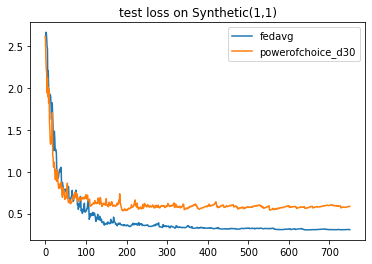

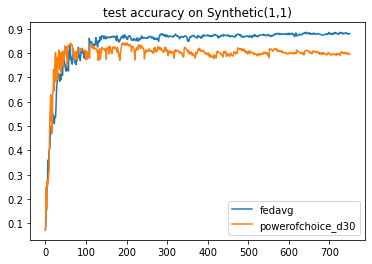

In [3]:
import flgo.experiment.analyzer
analysis_plan = {
    'Selector':{
        'task': task,
        'header':['fedavg', 'powerofchoice']
    },
    'Painter':{
        'Curve':[
            {'args':{'x': 'communication_round', 'y':'test_loss'}, 'fig_option':{'title':'test loss on Synthetic(1,1)'}},
            {'args':{'x': 'communication_round', 'y':'test_accuracy'},  'fig_option':{'title':'test accuracy on Synthetic(1,1)'}},
        ]
    }
}
flgo.experiment.analyzer.show(analysis_plan)